Погребная Кристина 
Тема проекта: Анализ публикаций телеграм-канала 

    ------ Формируем единый документ из выгрузок

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os

In [3]:
# Посмотрим как выглядит файл из выгрузки 
df = pd.read_excel("TGStat-Export-2025-09-04-20-13-18-3150.xlsx", skiprows=8)
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1.0,5760.0,30.12.2020 20:04,https://t.me/DtRoad/5760,перейти,347938.0,297.0,24.0,0.0,0.0,222.9,0.1,"У дружбы нет породы, а у любви — сертификата ...",
1,2.0,5481.0,10.12.2020 17:25,https://t.me/DtRoad/5481,перейти,251821.0,518.0,65.0,0.0,0.0,161.3,0.2,"​​Всем привет, это Максим Ликсутов! В 2014 г...",
2,3.0,5711.0,27.12.2020 21:21,https://t.me/DtRoad/5711,перейти,219521.0,526.0,17.0,0.0,1.0,140.6,0.2,"Сверкает, сияет гирляндами и увозит вас прямо...",
3,4.0,5390.0,03.12.2020 17:54,https://t.me/DtRoad/5390,перейти,216452.0,1177.0,75.0,0.0,1.0,138.6,0.5,❗️Тройка появится в вашем кошельке на телефон...,
4,5.0,5548.0,17.12.2020 20:00,https://t.me/DtRoad/5548,перейти,174847.0,657.0,7.0,0.0,1.0,112.0,0.4,«Авиамоторная» Некрасовской линии открылась в...,


In [5]:
# Информация по публикациям выгружена за каждый месяц в отдельный файл, нужно сделать единый DataFrame
# Импортируем библиотеку
import re

# путь к папке с файлами
path = r"C:\Users\Кристина"

# получаем список всех файлов .xlsx в папке
files = glob.glob(path + r"\*.xlsx")

print("Найдено файлов:", len(files))
print()  # смотрим что имеем

dfs = []

# читаем все файлы в цикле
for file in files: 
    if "Подписчики.xlsx" in file:
        continue  # пропускаем этот файл т.к. в нем нет информации по публикациям
    df_temp = pd.read_excel(file, skiprows=7)  # пропускаем шапку
    dfs.append(df_temp)


# объединяем всё в один датафрейм
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.iloc[:, :13]

print(df_all.shape)
# называем столбцы
df_all.columns = ["№", "ID поста", "Дата публикации", "Ссылка", "Статистика в TGStat", "Просмотров", "Пересылок", "Репостов", "Комментариев", "Реакций", "ERR%", "ER%", "Текст"]

# приводим ссылки к единому виду (чтобы разные варианты одной и той же ссылки считались одинаковыми)

def normalize_link(url):
    if pd.isna(url):
        return ""
    u = str(url).strip().lower()
    u = re.sub(r"\s+", "", u)      # убираем пробелы
    if '?' in u:                   # убираем UTM и параметры
        u = u.split('?')[0]
    u = u.rstrip('/')              # убираем завершающий /
    return u

df_all["Ссылка_норм"] = df_all["Ссылка"].apply(normalize_link)

# преобразуем дату в datetime
df_all["Дата публикации"] = pd.to_datetime(df_all["Дата публикации"], errors="coerce")

# делим датафрейм на с ссылками и без
df_with_links = df_all[df_all["Ссылка_норм"] != ""].copy()
df_no_links = df_all[df_all["Ссылка_норм"] == ""].copy()

# функция для выбора самой "лучшей" версии поста
def choose_best(group):
    # сортируем: сначала по дате (самая поздняя), потом по просмотрам
    return group.sort_values(by=["Дата публикации", "Просмотров"], ascending=[False, False]).iloc[0]

# удаляем дубли по ссылкам
df_with_links = df_with_links.groupby("Ссылка_норм", group_keys=False).apply(choose_best)

# удаляем дубли по тексту среди тех, у кого нет ссылки
df_no_links = df_no_links.groupby("Текст", group_keys=False).apply(choose_best)

# собираем обратно
df_all = pd.concat([df_with_links, df_no_links], ignore_index=True)

# убираем временную колонку
df_all = df_all.drop(columns=["Ссылка_норм"], errors="ignore")

print("Форма после удаления дублей:", df_all.shape)
df_all.head()



Найдено файлов: 73

(96314, 13)


C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\122882497.py:47: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_all["Дата публикации"] = pd.to_datetime(df_all["Дата публикации"], errors="coerce")


Форма после удаления дублей: (22785, 13)


C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\122882497.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_links = df_with_links.groupby("Ссылка_норм", group_keys=False).apply(choose_best)
C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\122882497.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_links = df_no_links.groupby("Текст", group_keys=False).apply(choose_best)


,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст
0,111.0,10000.0,2021-07-23 13:47:00,https://t.me/DtRoad/10000,перейти,15866.0,42.0,5.0,0.0,0.0,10.2,0.3,🚕Такси будущего уже в настоящем? Беспилотное...
1,51.0,10001.0,2021-07-23 14:40:00,https://t.me/DtRoad/10001,перейти,19074.0,56.0,4.0,0.0,0.0,12.2,0.3,💥Это не андеграундный клуб и не лофт — это га...
2,329.0,10008.0,2021-07-23 15:59:00,https://t.me/DtRoad/10008,перейти,9653.0,4.0,0.0,0.0,0.0,6.2,0.0,"🚦Рабочая неделя подходит к концу, и многие сп..."
3,364.0,10009.0,2021-07-23 16:00:00,https://t.me/DtRoad/10009,перейти,1.0,0.0,0.0,0.0,0.0,0.0,0.0,🚴‍♂️Вы рассказывали нам о своих любимых велом...
4,343.0,10012.0,2021-07-23 16:15:00,https://t.me/DtRoad/10012,перейти,9349.0,23.0,0.0,0.0,0.0,6.0,0.2,Быстро и удобно пополнить «Тройку» можно в пр...


In [7]:
# сохраняем файл
df_all.to_excel(r"C:\Users\Кристина\Объединённый_файл.xlsx", index=False)

    ------ Смотрим статистику по метрикам 

In [9]:
# Выбираем метрики, смотрим статистику

import pandas as pd

# Загружаем, полученный файл
df = pd.read_excel(r"C:\Users\Кристина\Объединённый_файл.xlsx")

# Преобразуем колонку "Дата публикации" в datetime
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce', dayfirst=True)

# Сортируем по дате от самой поздней к самой ранней
df = df.sort_values(by='Дата публикации', ascending=False)

# Создаем колонки "Год" и "Месяц"
df['Год'] = df['Дата публикации'].dt.year
df['Месяц'] = df['Дата публикации'].dt.month

# Метрики для анализа
metrics = ["Просмотров", "Пересылок", "Репостов", "Комментариев", "Реакций", "ERR%", "ER%"]

# Статистика за год
stats_year = df.groupby('Год')[metrics].agg(['mean', 'sum', 'max']).round(1)

# Статистика за каждый месяц в году
stats_month = df.groupby(['Год', 'Месяц'])[metrics].agg(['mean', 'sum', 'max']).round(1)

# Переименование колонок для удобства
stats_year.columns = ['_'.join(col).strip() for col in stats_year.columns]
stats_month.columns = ['_'.join(col).strip() for col in stats_month.columns]

# Вывод
print(stats_year)
print(stats_month)

      Просмотров_mean  Просмотров_sum  Просмотров_max  Пересылок_mean  \
Год                                                                     
2020          20238.8        49079060          790217            22.9   
2021          15532.1        59146316          326912            53.9   
2022          21655.4        90281376         1163258            69.7   
2023          24444.7       108534497          405754            76.7   
2024          20301.5        99660174          747017            67.3   
2025          18213.8        55260810          542983            80.3   

      Пересылок_sum  Пересылок_max  Репостов_mean  Репостов_sum  Репостов_max  \
Год                                                                             
2020          55529           5126            4.1          9988           113   
2021         205118           2559            3.2         12135           100   
2022         290784           4778            4.6         19192           245   
2023      

Построим графики по некторым показателям для наглядности

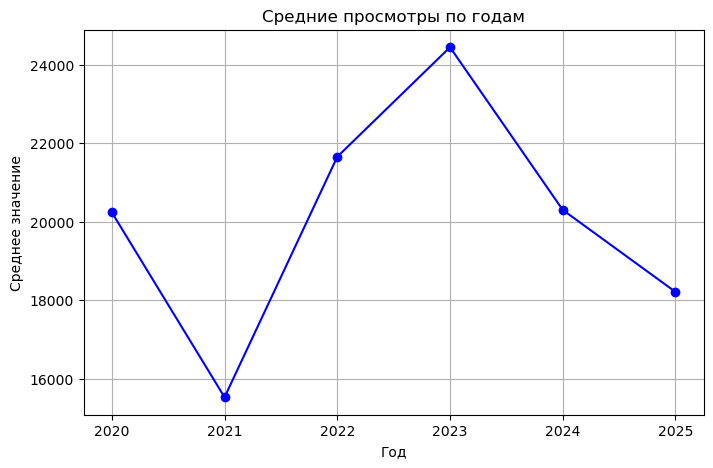

In [11]:
import matplotlib.pyplot as plt

# Средние просмотры по годам 
plt.figure(figsize=(8, 5))
plt.plot(stats_year.index, stats_year["Просмотров_mean"], marker="o", color="blue")
plt.title("Средние просмотры по годам")
plt.xlabel("Год")
plt.ylabel("Среднее значение")
plt.grid(True)
plt.show()

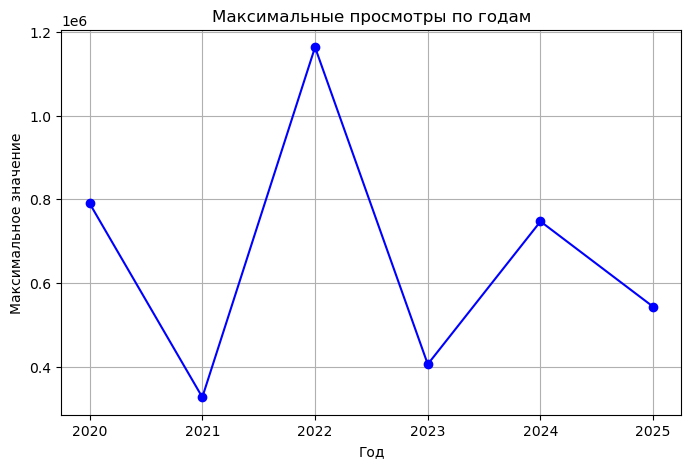

In [13]:
# Максимальные просмотры по годам 
plt.figure(figsize=(8, 5))
plt.plot(stats_year.index, stats_year["Просмотров_max"], marker="o", color="blue")
plt.title("Максимальные просмотры по годам")
plt.xlabel("Год")
plt.ylabel("Максимальное значение")
plt.grid(True)
plt.show()

In [15]:
import pandas as pd
from IPython.display import display  # чтобы красиво показывать таблицы

# Убедимся, что колонка с датой в формате datetime
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce', dayfirst=True)
df['Год'] = df['Дата публикации'].dt.year

# Для каждого года выбираем публикацию с максимальным количеством просмотров
top_posts = df.loc[df.groupby("Год")["Просмотров"].idxmax(),
                   ["Год", "Дата публикации", "Просмотров", "Ссылка", "Текст"]]

# Немного укоротим текст публикации для удобства просмотра
top_posts["Текст"] = top_posts["Текст"].astype(str).str.replace("\n", " ", regex=False).str.slice(0, 250)

# Сбросим индекс
top_posts = top_posts.reset_index(drop=True)

# Выводим в виде таблицы
display(top_posts)


,Год,Дата публикации,Просмотров,Ссылка,Текст
0,2020,2020-03-29 19:56:00,790217,https://t.me/DtRoad/2453,⚡️Дополнительные меры по борьбе с коронавирус...
1,2021,2021-01-03 14:07:00,326912,https://t.me/DtRoad/5802,Сегодня поезда «Филевской» линии повели перво...
2,2022,2022-03-18 16:33:00,1163258,https://t.me/DtRoad/15049,📈В течение дня и во время концерта на Лужника...
3,2023,2023-10-11 13:25:00,405754,https://t.me/DtRoad/30208,"Козловский В. Н., руководитель Московского ме..."
4,2024,2024-03-22 22:58:00,747017,https://t.me/DtRoad/35161,"Как сообщили в компании Яндекс, Яндекс Такси ..."
5,2025,2025-06-09 10:01:00,542983,https://t.me/DtRoad/48717,"🚀 Именно вы решите, какой рисунок полетит в к..."


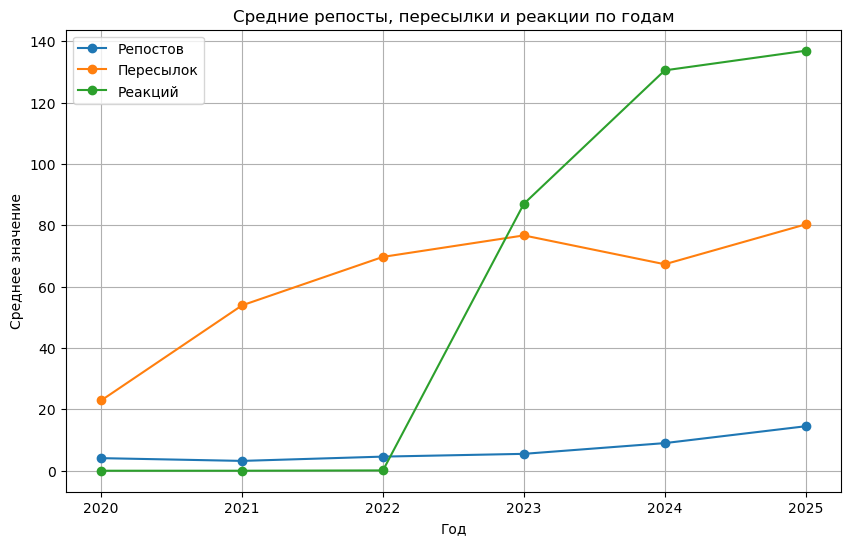

In [17]:
# Средние репосты, пересылки, реакции по годам
plt.figure(figsize=(10, 6))
for metric in ["Репостов", "Пересылок", "Реакций"]:
    plt.plot(stats_year.index, stats_year[f"{metric}_mean"], marker="o", label=metric)
plt.title("Средние репосты, пересылки и реакции по годам")
plt.xlabel("Год")
plt.ylabel("Среднее значение")
plt.legend()
plt.grid(True)
plt.show()

Сводная таблица (средние просмотры по кварталам):
Квартал        1        2        3        4
Год                                        
2020     41102.6  24620.4  13550.7  20325.1
2021     15894.5  16007.9  14649.4  15606.1
2022     20993.7  22025.2  20725.3  22843.0
2023     25343.6  23468.1  24765.5  24368.7
2024     24381.6  23041.7  18042.4  16102.4
2025     17095.0  19527.2  17647.0      NaN


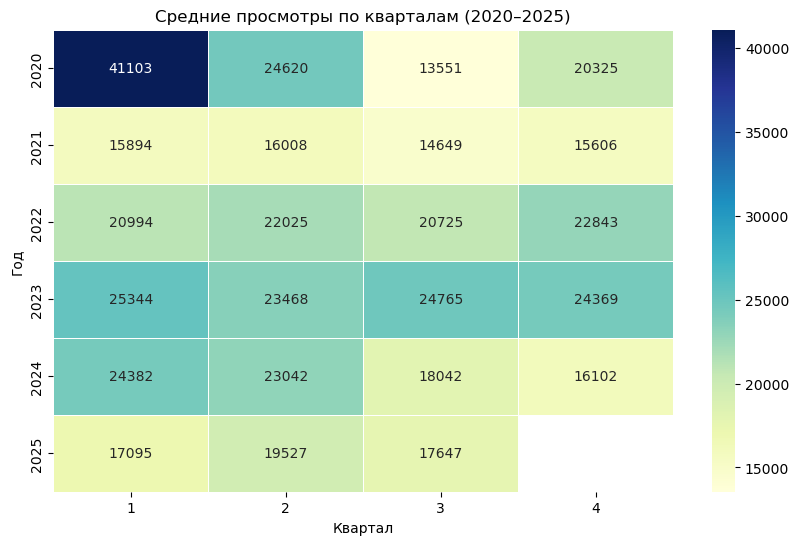

In [19]:
# Посмотрим средние охваты по кварталам


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем файл (поменяй путь на свой)
file_path = r"C:\Users\Кристина\Объединённый_файл.xlsx"
df = pd.read_excel(file_path)

# Приводим дату в datetime
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['Дата публикации']).copy()

# Добавляем год и квартал
df['Год'] = df['Дата публикации'].dt.year
df['Квартал'] = df['Дата публикации'].dt.quarter

# Считаем средние просмотры по годам и кварталам
quarterly_stats = df.groupby(['Год', 'Квартал'])['Просмотров'].mean().reset_index()

# Строим сводную таблицу
pivot_table = quarterly_stats.pivot(index='Год', columns='Квартал', values='Просмотров')

print("Сводная таблица (средние просмотры по кварталам):")
print(pivot_table.round(1))

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Средние просмотры по кварталам (2020–2025)")
plt.xlabel("Квартал")
plt.ylabel("Год")
plt.show()


In [21]:
# Смотрим количество постов по годам и месяцам
# Убедимся, что колонка с датой в datetime
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['Дата публикации']).copy()

# Добавляем колонки "Год" и "Месяц"
df['Год'] = df['Дата публикации'].dt.year
df['Месяц'] = df['Дата публикации'].dt.month


# Количество постов по годам
posts_year = df.groupby('Год').size().reset_index(name="Количество постов")

# Количество постов по месяцам
posts_month = df.groupby(['Год', 'Месяц']).size().reset_index(name="Количество постов")

print(posts_year)
print(posts_month)

    Год  Количество постов
0  2020               2425
1  2021               3808
2  2022               4169
3  2023               4440
4  2024               4909
5  2025               3034
     Год  Месяц  Количество постов
0   2020      3                104
1   2020      4                213
2   2020      5                243
3   2020      6                235
4   2020      7                235
..   ...    ...                ...
62  2025      5                397
63  2025      6                383
64  2025      7                446
65  2025      8                414
66  2025      9                 64

[67 rows x 3 columns]


C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1919195935.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=posts_year, x='Год', y='Количество постов', palette="Blues_d")


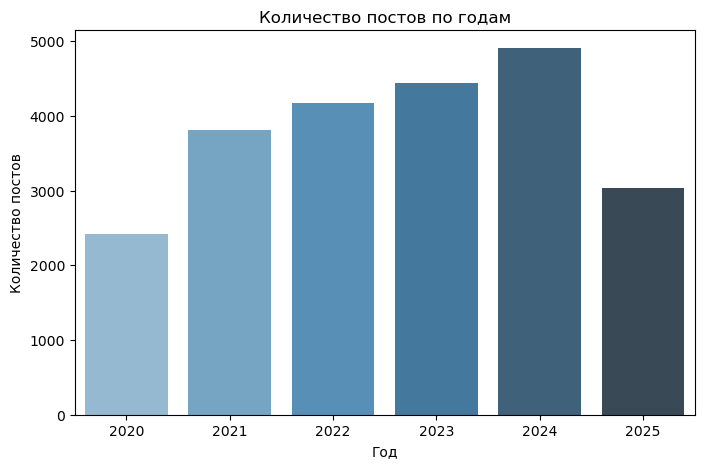

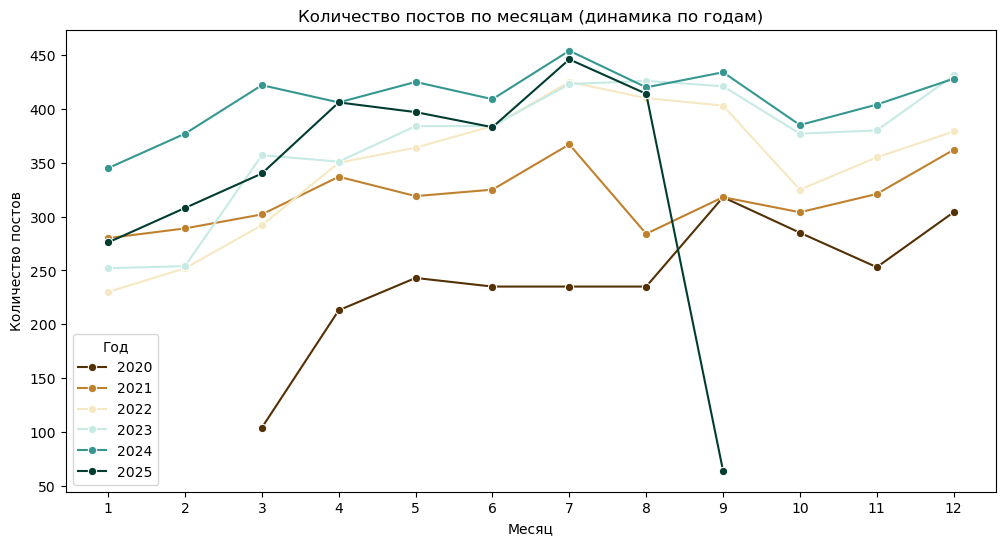

In [23]:
# Посмотроим графики по количеству публикаций за пять лет по годам и месяца. Это позволит нам посмотреть визуально динамику и, возмодно, найти закономерности

import matplotlib.pyplot as plt
import seaborn as sns

# График по годам 
plt.figure(figsize=(8,5))
sns.barplot(data=posts_year, x='Год', y='Количество постов', palette="Blues_d")
plt.title("Количество постов по годам")
plt.xlabel("Год")
plt.ylabel("Количество постов")
plt.show()

# График по месяцам (сезонность)
plt.figure(figsize=(12,6))
sns.lineplot(data=posts_month, x='Месяц', y='Количество постов', hue='Год', marker="o", palette="BrBG")
plt.title("Количество постов по месяцам (динамика по годам)")
plt.xlabel("Месяц")
plt.ylabel("Количество постов")
plt.xticks(range(1,13))
plt.legend(title="Год")
plt.show()

Вывод по полученным данным: мы видим, что за пять лет 2023 год имеет наибольшее значение по показателю «среднее количество просмотров», то есть в этом году охваты по просмотрам были больше в сравнении с остальными годами. Однако публикация, имеющая максимальное количество просмотров, — 2022 год. Данная публикация связана с митинг-концертом «Крымская весна» 18 марта 2022 года на московском стадионе «Лужники».

С 2022 года наблюдается рост репостов и реакций. Рост реакций связан с появлением данной функции в Телеграме.

Согласно тепловому графику, есть тенденция увеличения охватов с первого квартала 2022 по второй квартал 2024 года. Что касается первого квата 2020 года, то за отчетный период было опубликовано 104 публикации, что примерно на 100 публикаций меньше, из-за чего может быть такой средний показатель.

Наблюдается тен, что наименьшее количество публикаций в январе, а к концу года их число увеличивается. В целом количество публикаций в течении года не равномерное. Можно отметить, что пик активности приходится на июль месяц. 5 лет.

------ Составим рейтинг публикаций по показателям: просмотры, репосты, пересылки

In [25]:
# Смотрим ТОП по просмотрам

# удаляем дубликаты по колонке "Ссылка"
df = df.drop_duplicates(subset="Ссылка", keep="first")

results = []

# Перебираем все уникальные года
for year in sorted(df['Год'].dropna().unique()):
    df_year = df[df['Год'] == year].copy()
    
    # Топ-5 по просмотрам
    top_views = df_year.sort_values(by="Просмотров", ascending=False).head(5)
    top_views["Категория"] = f"Топ по просмотрам {year}"
    
    results.append(top_views)

# Объединяем в один датафрейм
top_posts = pd.concat(results).reset_index(drop=True)

# Немного укоротим текст для удобства просмотра
if "Текст" in top_posts.columns:
    top_posts["Текст"] = (
        top_posts["Текст"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.slice(0, 400)
    )

# Смотрим первые 30 строк
top_posts.head(30)



,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст,Год,Квартал,Месяц,Категория
0,1,2453,2020-03-29 19:56:00,https://t.me/DtRoad/2453,перейти,790217,0,0,0,0,506.1,0.0,⚡️Дополнительные меры по борьбе с коронавирус...,2020,1,3,Топ по просмотрам 2020
1,1,5128,2020-11-12 20:00:00,https://t.me/DtRoad/5128,перейти,695237,5126,113,0,0,445.3,0.7,😱На «Площади Революции» 110% в масках. Фигуры...,2020,4,11,Топ по просмотрам 2020
2,2,5228,2020-11-21 11:19:00,https://t.me/DtRoad/5228,перейти,468851,678,40,0,0,300.3,0.1,Уже год ежедневно тысячи людей садятся на пое...,2020,4,11,Топ по просмотрам 2020
3,2,2456,2020-03-29 20:57:00,https://t.me/DtRoad/2456,перейти,468067,0,0,0,0,299.8,0.0,"❗️Ограничение движения личного и служебного, ...",2020,1,3,Топ по просмотрам 2020
4,3,2466,2020-03-30 18:15:00,https://t.me/DtRoad/2466,перейти,398284,0,2,0,0,255.1,0.0,Ответы на главные вопросы о режиме самоизоляц...,2020,1,3,Топ по просмотрам 2020
5,1,5802,2021-01-03 14:07:00,https://t.me/DtRoad/5802,перейти,326912,976,38,0,0,209.4,0.3,Сегодня поезда «Филевской» линии повели перво...,2021,1,1,Топ по просмотрам 2021
6,1,8082,2021-04-28 14:36:00,https://t.me/DtRoad/8082,перейти,284834,1235,34,0,0,182.4,0.4,Дорогая Анастасия Ивлеева! Нам снова пришлос...,2021,2,4,Топ по просмотрам 2021
7,2,8083,2021-04-28 16:04:00,https://t.me/DtRoad/8083,перейти,179080,86,7,0,0,114.7,0.0,"🚨Сегодня, 28 апреля — День скорой помощи. Вра...",2021,2,4,Топ по просмотрам 2021
8,1,6996,2021-03-11 14:29:00,https://t.me/DtRoad/6996,перейти,163721,271,11,0,0,104.9,0.2,"Каким будет городской транспорт завтра, через...",2021,1,3,Топ по просмотрам 2021
9,1,8631,2021-05-24 10:37:00,https://t.me/DtRoad/8631,перейти,159041,283,21,0,0,101.9,0.2,"🕵🏻‍♀️Осторожно, мошенники! Иногда к водителям...",2021,2,5,Топ по просмотрам 2021


In [27]:
# Смотрим ТОП по репостам

# удаляем дубликаты по колонке "Ссылка"
df = df.drop_duplicates(subset="Ссылка", keep="first")

results_reposts = []

# Перебираем все уникальные года
for year in sorted(df['Год'].dropna().unique()):
    df_year = df[df['Год'] == year].copy()
    
    # Топ-5 по репостам
    top_reposts = df_year.sort_values(by="Репостов", ascending=False).head(5)
    top_reposts["Категория"] = f"Топ по репостам {year}"
    
    results_reposts.append(top_reposts)

# Объединяем в один датафрейм
top_posts_reposts = pd.concat(results_reposts).reset_index(drop=True)

# Укорачиваем текст
if "Текст" in top_posts_reposts.columns:
    top_posts_reposts["Текст"] = (
        top_posts_reposts["Текст"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.slice(0, 200)
    )

# Смотрим таблицу
top_posts_reposts.head(30)


,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст,Год,Квартал,Месяц,Категория
0,1,5128,2020-11-12 20:00:00,https://t.me/DtRoad/5128,перейти,695237,5126,113,0,0,445.3,0.7,😱На «Площади Революции» 110% в масках. Фигуры...,2020,4,11,Топ по репостам 2020
1,7,2545,2020-04-10 11:25:00,https://t.me/DtRoad/2545,перейти,183450,0,90,0,0,117.5,0.0,"Сегодня во время совместного рейда ГИБДД, МАД...",2020,2,4,Топ по репостам 2020
2,3,2899,2020-05-12 19:20:00,https://t.me/DtRoad/2899,перейти,270887,0,89,0,0,173.5,0.0,❗️Сегодня BBC опубликовали информацию о закуп...,2020,2,5,Топ по репостам 2020
3,7,3171,2020-06-09 08:30:00,https://t.me/DtRoad/3171,перейти,68723,0,78,0,0,44.0,0.0,"Всем привет, это Максим Ликсутов! Вы вчера у...",2020,2,6,Топ по репостам 2020
4,4,5390,2020-12-03 17:54:00,https://t.me/DtRoad/5390,перейти,216452,1177,75,0,1,138.6,0.5,❗️Тройка появится в вашем кошельке на телефон...,2020,4,12,Топ по репостам 2020
5,17,7510,2021-04-03 11:40:00,https://t.me/DtRoad/7510,перейти,27596,285,100,0,0,17.7,1.0,❗️Мы запускаем велопрокат и прокат самокатов ...,2021,2,4,Топ по репостам 2021
6,154,7982,2021-04-23 10:02:00,https://t.me/DtRoad/7982,перейти,13978,128,82,0,0,9.0,0.9,"❗️В праздничные дни 1, 3, 9 и 10 мая парковки...",2021,2,4,Топ по репостам 2021
7,7,12173,2021-11-03 12:49:00,https://t.me/DtRoad/12173,перейти,42261,407,76,0,0,27.1,1.0,🚗30 км/ч — такая максимально разрешенная скор...,2021,4,11,Топ по репостам 2021
8,26,9830,2021-07-15 11:18:00,https://t.me/DtRoad/9830,перейти,23784,559,73,0,0,15.2,2.4,"​​Всем привет, это Максим Ликсутов! Как вы уж...",2021,3,7,Топ по репостам 2021
9,3,6034,2021-01-18 10:30:00,https://t.me/DtRoad/6034,перейти,108341,289,72,0,0,69.4,0.3,"Всем привет, это Максим Ликсутов! Ещё в 2020...",2021,1,1,Топ по репостам 2021


In [29]:
# Смотрим ТОП по пересылкам

# удаляем дубликаты по колонке "Ссылка"
df = df.drop_duplicates(subset="Ссылка", keep="first")

results_forwards = []

# Перебираем все уникальные года
for year in sorted(df['Год'].dropna().unique()):
    df_year = df[df['Год'] == year].copy()
    
    # Топ-5 по пересылкам
    top_forwards = df_year.sort_values(by="Пересылок", ascending=False).head(5)
    top_forwards["Категория"] = f"Топ по пересылкам {year}"
    
    results_forwards.append(top_forwards)

# Объединяем в один датафрейм
top_posts_forwards = pd.concat(results_forwards).reset_index(drop=True)

# Укорачиваем текст
if "Текст" in top_posts_forwards.columns:
    top_posts_forwards["Текст"] = (
        top_posts_forwards["Текст"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.slice(0, 200)
    )

# Смотрим таблицу
top_posts_forwards.head(30)


,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст,Год,Квартал,Месяц,Категория
0,1,5128,2020-11-12 20:00:00,https://t.me/DtRoad/5128,перейти,695237,5126,113,0,0,445.3,0.7,😱На «Площади Революции» 110% в масках. Фигуры...,2020,4,11,Топ по пересылкам 2020
1,12,4981,2020-11-02 13:00:00,https://t.me/DtRoad/4981,перейти,69128,1490,56,0,1,44.3,2.2,📱Использование водителем телефона во время дв...,2020,4,11,Топ по пересылкам 2020
2,4,5390,2020-12-03 17:54:00,https://t.me/DtRoad/5390,перейти,216452,1177,75,0,1,138.6,0.5,❗️Тройка появится в вашем кошельке на телефон...,2020,4,12,Топ по пересылкам 2020
3,6,2423,2020-03-26 11:40:00,https://t.me/DtRoad/2423,перейти,202359,1016,15,0,1,129.6,0.5,Новая аналитика по состоянию на 10:00 утра се...,2020,1,3,Топ по пересылкам 2020
4,16,2446,2020-03-28 18:56:00,https://t.me/DtRoad/2446,перейти,42700,746,33,0,1,27.3,1.7,"Решили напомнить вам, кого нужно оберегать в ...",2020,1,3,Топ по пересылкам 2020
5,1,9615,2021-07-07 09:00:00,https://t.me/DtRoad/9615,перейти,141049,2559,27,0,0,90.3,1.8,🔥Международный фестиваль NFT-искусства 8g наз...,2021,3,7,Топ по пересылкам 2021
6,1,8082,2021-04-28 14:36:00,https://t.me/DtRoad/8082,перейти,284834,1235,34,0,0,182.4,0.4,Дорогая Анастасия Ивлеева! Нам снова пришлос...,2021,2,4,Топ по пересылкам 2021
7,11,6083,2021-01-20 13:30:00,https://t.me/DtRoad/6083,перейти,54245,1145,18,0,0,34.7,2.1,🚘С 1 марта изменятся правила прохождения техо...,2021,1,1,Топ по пересылкам 2021
8,12,7895,2021-04-18 12:38:00,https://t.me/DtRoad/7895,перейти,31758,1069,23,0,1,20.3,3.4,Слово дня👆🏻 Это откидное сиденье в транспорт...,2021,2,4,Топ по пересылкам 2021
9,1,5802,2021-01-03 14:07:00,https://t.me/DtRoad/5802,перейти,326912,976,38,0,0,209.4,0.3,Сегодня поезда «Филевской» линии повели перво...,2021,1,1,Топ по пересылкам 2021


In [31]:
# Смотрим ТОП по реакциям

# удаляем дубликаты по колонке "Ссылка"
df = df.drop_duplicates(subset="Ссылка", keep="first")

results_reactions = []

# Перебираем только за с 2023 года т.к. реакции в Телеграме появились в 2023
for year in [2023, 2024, 2025]:
    df_year = df[df['Год'] == year].copy()
    
    # Топ-5 по реакциям
    top_reactions = df_year.sort_values(by="Реакций", ascending=False).head(5)
    top_reactions["Категория"] = f"Топ по реакциям {year}"
    
    results_forwards.append(top_forwards)

# Объединяем в один датафрейм
top_posts_reactions = pd.concat(results_forwards).reset_index(drop=True)

# Укорачиваем текст
if "Текст" in top_posts_forwards.columns:
    top_posts_reactions["Текст"] = (
        top_posts_reactions["Текст"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.slice(0, 200)
    )

# Смотрим таблицу
top_posts_reactions.head(30)


,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст,Год,Квартал,Месяц,Категория
0,1,5128,2020-11-12 20:00:00,https://t.me/DtRoad/5128,перейти,695237,5126,113,0,0,445.3,0.7,😱На «Площади Революции» 110% в масках. Фигуры...,2020,4,11,Топ по пересылкам 2020
1,12,4981,2020-11-02 13:00:00,https://t.me/DtRoad/4981,перейти,69128,1490,56,0,1,44.3,2.2,📱Использование водителем телефона во время дв...,2020,4,11,Топ по пересылкам 2020
2,4,5390,2020-12-03 17:54:00,https://t.me/DtRoad/5390,перейти,216452,1177,75,0,1,138.6,0.5,❗️Тройка появится в вашем кошельке на телефон...,2020,4,12,Топ по пересылкам 2020
3,6,2423,2020-03-26 11:40:00,https://t.me/DtRoad/2423,перейти,202359,1016,15,0,1,129.6,0.5,Новая аналитика по состоянию на 10:00 утра се...,2020,1,3,Топ по пересылкам 2020
4,16,2446,2020-03-28 18:56:00,https://t.me/DtRoad/2446,перейти,42700,746,33,0,1,27.3,1.7,"Решили напомнить вам, кого нужно оберегать в ...",2020,1,3,Топ по пересылкам 2020
5,1,9615,2021-07-07 09:00:00,https://t.me/DtRoad/9615,перейти,141049,2559,27,0,0,90.3,1.8,🔥Международный фестиваль NFT-искусства 8g наз...,2021,3,7,Топ по пересылкам 2021
6,1,8082,2021-04-28 14:36:00,https://t.me/DtRoad/8082,перейти,284834,1235,34,0,0,182.4,0.4,Дорогая Анастасия Ивлеева! Нам снова пришлос...,2021,2,4,Топ по пересылкам 2021
7,11,6083,2021-01-20 13:30:00,https://t.me/DtRoad/6083,перейти,54245,1145,18,0,0,34.7,2.1,🚘С 1 марта изменятся правила прохождения техо...,2021,1,1,Топ по пересылкам 2021
8,12,7895,2021-04-18 12:38:00,https://t.me/DtRoad/7895,перейти,31758,1069,23,0,1,20.3,3.4,Слово дня👆🏻 Это откидное сиденье в транспорт...,2021,2,4,Топ по пересылкам 2021
9,1,5802,2021-01-03 14:07:00,https://t.me/DtRoad/5802,перейти,326912,976,38,0,0,209.4,0.3,Сегодня поезда «Филевской» линии повели перво...,2021,1,1,Топ по пересылкам 2021


In [33]:
import pandas as pd

# Объединяем все топы в один
all_tops = pd.concat([
    top_posts,           # просмотры
    top_posts_reposts,   # репосты
    top_posts_forwards,  # пересылки
    top_posts_reactions  # реакции
], ignore_index=True)

# Убираем дубликаты: сначала по ссылке, потом по тексту
all_tops = all_tops.drop_duplicates(subset=["Ссылка"], keep="first")
all_tops = all_tops.drop_duplicates(subset=["Текст"], keep="first")

# Обрезаем текст до 500 символов
if "Текст" in all_tops.columns:
    all_tops["Текст"] = (
        all_tops["Текст"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.slice(0, 500)
    )

# Сбрасываем индекс
all_tops = all_tops.reset_index(drop=True)

# Смотрим результат
display(all_tops)

print(f"В итоговом топе осталось {len(all_tops)} уникальных публикаций")


,№,ID поста,Дата публикации,Ссылка,Статистика в TGStat,Просмотров,Пересылок,Репостов,Комментариев,Реакций,ERR%,ER%,Текст,Год,Квартал,Месяц,Категория
0,1,2453,2020-03-29 19:56:00,https://t.me/DtRoad/2453,перейти,790217,0,0,0,0,506.1,0.0,⚡️Дополнительные меры по борьбе с коронавирус...,2020,1,3,Топ по просмотрам 2020
1,1,5128,2020-11-12 20:00:00,https://t.me/DtRoad/5128,перейти,695237,5126,113,0,0,445.3,0.7,😱На «Площади Революции» 110% в масках. Фигуры...,2020,4,11,Топ по просмотрам 2020
2,2,5228,2020-11-21 11:19:00,https://t.me/DtRoad/5228,перейти,468851,678,40,0,0,300.3,0.1,Уже год ежедневно тысячи людей садятся на пое...,2020,4,11,Топ по просмотрам 2020
3,2,2456,2020-03-29 20:57:00,https://t.me/DtRoad/2456,перейти,468067,0,0,0,0,299.8,0.0,"❗️Ограничение движения личного и служебного, ...",2020,1,3,Топ по просмотрам 2020
4,3,2466,2020-03-30 18:15:00,https://t.me/DtRoad/2466,перейти,398284,0,2,0,0,255.1,0.0,Ответы на главные вопросы о режиме самоизоляц...,2020,1,3,Топ по просмотрам 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,24,35741,2024-04-09 12:30:00,https://t.me/DtRoad/35741,перейти,57083,3133,74,0,152,36.5,5.8,🚴‍♂️🚴‍♂️🚴‍♂️ Мы открываем регистрацию на Весе...,2024,2,4,Топ по пересылкам 2024
75,1,48092,2025-05-20 18:00:00,https://t.me/DtRoad/48092,перейти,230053,5112,74,0,1038,146.9,2.7,С 1 июня 2025 года изменятся тарифы на проезд...,2025,2,5,Топ по пересылкам 2025
76,5,47147,2025-04-21 11:01:00,https://t.me/DtRoad/47147,перейти,53995,3911,42,0,183,34.5,7.6,🤩 Сколько?! Целых 5 велофестивалей проведем в...,2025,2,4,Топ по пересылкам 2025
77,2,50665,2025-08-05 11:01:00,https://t.me/DtRoad/50665,перейти,101407,2698,158,0,163,65.0,2.8,🏃‍♂️ Садовое кольцо вновь станет спортивным ц...,2025,3,8,Топ по пересылкам 2025


В итоговом топе осталось 79 уникальных публикаций


----- Тематическая кластеризация общего ТОПа

In [35]:
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

# Загружаем стоп-слова
nltk.download("stopwords")
stop_words = stopwords.words("russian")

# Берём только тексты из итогового ТОПа
texts = all_tops["Текст"].dropna().astype(str).tolist()

# Очистка текста
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", " ", text)  # убираем всё кроме букв и цифр
    text = re.sub(r"\s+", " ", text).strip()
    return text

texts_clean = [clean_text(t) for t in texts]

# Векторизация TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
X = vectorizer.fit_transform(texts_clean)

# Кластеризация
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Добавим к датафрейму
all_tops["Кластер"] = labels

# Посмотрим тексты по кластерам
for i in range(n_clusters):
    print(f"\n--- Тема {i} ---")
    sample = all_tops[all_tops["Кластер"] == i].head(10)  # первые 10 постов каждой темы
    display(sample[["Год", "Ссылка", "Текст"]])

# Ключевые слова для каждой темы
terms = vectorizer.get_feature_names_out()
for i in range(n_clusters):
    cluster_terms = kmeans.cluster_centers_[i].argsort()[-10:][::-1]
    print(f"\nТема {i}: ", [terms[ind] for ind in cluster_terms])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- Тема 0 ---


,Год,Ссылка,Текст
3,2020,https://t.me/DtRoad/2456,"❗️Ограничение движения личного и служебного, ..."
6,2021,https://t.me/DtRoad/8082,Дорогая Анастасия Ивлеева! Нам снова пришлос...
7,2021,https://t.me/DtRoad/8083,"🚨Сегодня, 28 апреля — День скорой помощи. Вра..."
34,2021,https://t.me/DtRoad/7510,❗️Мы запускаем велопрокат и прокат самокатов ...
40,2022,https://t.me/DtRoad/15061,🦸🏻‍♂️Наши сотрудники Дорожного патруля ЦОДД М...
43,2022,https://t.me/DtRoad/18079,📚Летние каникулы не повод забывать о правилах...
44,2023,https://t.me/DtRoad/27547,Любите ездить на электросамокате? Любите и па...
45,2023,https://t.me/DtRoad/23625,🐈1 марта в России отмечают День кошек — сегод...
74,2024,https://t.me/DtRoad/35741,🚴‍♂️🚴‍♂️🚴‍♂️ Мы открываем регистрацию на Весе...
77,2025,https://t.me/DtRoad/50665,🏃‍♂️ Садовое кольцо вновь станет спортивным ц...



--- Тема 1 ---


,Год,Ссылка,Текст
5,2021,https://t.me/DtRoad/5802,Сегодня поезда «Филевской» линии повели перво...
19,2023,https://t.me/DtRoad/25153,"Любители мощных моторов и встречного ветра, ж..."
26,2025,https://t.me/DtRoad/48922,🎉 Лето 1931 года изменило историю Москвы навс...
39,2022,https://t.me/DtRoad/20754,❗️С 12 ноября 2022 года на срок около 6 месяц...
41,2022,https://t.me/DtRoad/20813,❗️С 12 ноября на срок около 6 месяцев закроем...
42,2022,https://t.me/DtRoad/21185,С 12 ноября ориентировочно в течение 6 месяце...
65,2022,https://t.me/DtRoad/21265,"Рассказываем, как проходит первый день ограни..."
66,2022,https://t.me/DtRoad/21288,Сегодня первое рабочее утро ограничений на уч...



--- Тема 2 ---


,Год,Ссылка,Текст
0,2020,https://t.me/DtRoad/2453,⚡️Дополнительные меры по борьбе с коронавирус...
9,2021,https://t.me/DtRoad/8631,"🕵🏻‍♀️Осторожно, мошенники! Иногда к водителям..."
13,2022,https://t.me/DtRoad/20733,🛩Теперь оплатить «Аэроэкспресс» на сайте комп...
20,2024,https://t.me/DtRoad/35161,"Как сообщили в компании Яндекс, Яндекс Такси ..."
35,2021,https://t.me/DtRoad/7982,"❗️В праздничные дни 1, 3, 9 и 10 мая парковки..."



--- Тема 3 ---


,Год,Ссылка,Текст
11,2022,https://t.me/DtRoad/14896,Вслед за решением Мэра Москвы С. Собянина Тра...
14,2022,https://t.me/DtRoad/19770,10 сентября Президент России Владимир Путин и...
30,2020,https://t.me/DtRoad/2545,"Сегодня во время совместного рейда ГИБДД, МАД..."
46,2023,https://t.me/DtRoad/29195,1⃣2⃣3⃣4⃣5⃣ Запущено движение по южному участ...
62,2021,https://t.me/DtRoad/9615,🔥Международный фестиваль NFT-искусства 8g наз...
78,2025,https://t.me/DtRoad/49252,❗️ Москвичи сделали свой выбор: на месте моно...



--- Тема 4 ---


,Год,Ссылка,Текст
2,2020,https://t.me/DtRoad/5228,Уже год ежедневно тысячи людей садятся на пое...
12,2022,https://t.me/DtRoad/20224,❗️30 сентября будут временно закрыты для движ...
50,2024,https://t.me/DtRoad/36488,ЦОДД: 9 мая будут закрыты для движения трансп...
57,2025,https://t.me/DtRoad/47388,"🚴‍♀️ Велосипедисты, внимание! Мы открываем ре..."
69,2023,https://t.me/DtRoad/23801,🚊 На «Текстильщиках» БКЛ заработал новый серв...
71,2024,https://t.me/DtRoad/38215,Рассказываем о маршруте Ночного велофестиваля...
72,2024,https://t.me/DtRoad/40533,🚲 Представляем маршрут Осеннего велофестиваля...



--- Тема 5 ---


,Год,Ссылка,Текст
15,2023,https://t.me/DtRoad/30208,"Козловский В. Н., руководитель Московского ме..."
63,2021,https://t.me/DtRoad/6083,🚘С 1 марта изменятся правила прохождения техо...
64,2021,https://t.me/DtRoad/7895,Слово дня👆🏻 Это откидное сиденье в транспорт...
68,2023,https://t.me/DtRoad/29964,С 15 октября изменится ряд тарифов на проезд ...
73,2024,https://t.me/DtRoad/36572,С 20 мая изменятся тарифы на проезд в городск...
75,2025,https://t.me/DtRoad/48092,С 1 июня 2025 года изменятся тарифы на проезд...



--- Тема 6 ---


,Год,Ссылка,Текст
1,2020,https://t.me/DtRoad/5128,😱На «Площади Революции» 110% в масках. Фигуры...
21,2024,https://t.me/DtRoad/35166,На станции метро «Мякинино» работают ведомств...
22,2024,https://t.me/DtRoad/35169,Сегодня в концертном зале Крокус произошла тр...
27,2025,https://t.me/DtRoad/48992,От витражей и мозаик до современных архитекту...
31,2020,https://t.me/DtRoad/2899,❗️Сегодня BBC опубликовали информацию о закуп...
33,2020,https://t.me/DtRoad/5390,❗️Тройка появится в вашем кошельке на телефон...



--- Тема 7 ---


,Год,Ссылка,Текст
24,2024,https://t.me/DtRoad/42876,"🤗 Электробусы появились там, где вы их так жд..."
29,2025,https://t.me/DtRoad/50122,Не пропустите новый выпуск проекта «Хроники М...
32,2020,https://t.me/DtRoad/3171,"Всем привет, это Максим Ликсутов! Вы вчера у..."
37,2021,https://t.me/DtRoad/9830,"​​Всем привет, это Максим Ликсутов! Как вы уж..."
38,2021,https://t.me/DtRoad/6034,"Всем привет, это Максим Ликсутов! Ещё в 2020..."
47,2023,https://t.me/DtRoad/24880,📱Вы можете легко и быстро покупать билеты на ...
48,2023,https://t.me/DtRoad/23603,"Событие, которого давно ждали, свершилось — д..."
49,2024,https://t.me/DtRoad/35410,Как не пропустить изменения в работе маршруто...
52,2024,https://t.me/DtRoad/39101,⚡️ Больше новых электробусов — больше заботы ...
55,2025,https://t.me/DtRoad/45169,🚌🚌🚌 Отвечаем на один из популярных вопросов: ...



--- Тема 8 ---


,Год,Ссылка,Текст
4,2020,https://t.me/DtRoad/2466,Ответы на главные вопросы о режиме самоизоляц...
8,2021,https://t.me/DtRoad/6996,"Каким будет городской транспорт завтра, через..."
10,2022,https://t.me/DtRoad/15049,📈В течение дня и во время концерта на Лужника...
18,2023,https://t.me/DtRoad/31187,🎭 Более 50 ночных мероприятий прошли в метро ...
23,2024,https://t.me/DtRoad/35178,Сегодня большое количество желающих помочь по...
28,2025,https://t.me/DtRoad/49724,"Продюсер, композитор, музыкант, фронтмен. В ..."
51,2024,https://t.me/DtRoad/37010,Последние дни получаем сообщения от мотоцикли...
53,2024,https://t.me/DtRoad/41513,🅿️ Новая функция в приложении «Парковки Росси...
54,2025,https://t.me/DtRoad/46800,🏍 Мотофестиваль 2025 — это будет зажигательно...
59,2020,https://t.me/DtRoad/4981,📱Использование водителем телефона во время дв...



--- Тема 9 ---


,Год,Ссылка,Текст
16,2023,https://t.me/DtRoad/29784,Почему жители Москвы пользуются сервисом арен...
17,2023,https://t.me/DtRoad/30832,⚒ Продолжаем реконструкцию самого большого го...
25,2025,https://t.me/DtRoad/48717,"🚀 Именно вы решите, какой рисунок полетит в к..."
36,2021,https://t.me/DtRoad/12173,🚗30 км/ч — такая максимально разрешенная скор...



Тема 0:  ['самокаты', 'день', 'апреля', 'любите', 'велосипеды', 'празднику', 'движения', 'цодд', 'марта', 'который']

Тема 1:  ['линии', 'орехово', 'замоскворецкой', 'года', '12', 'месяцев', 'ноября', 'автозаводская', 'тоннель', 'автозаводской']

Тема 2:  ['компании', 'такси', 'поездки', 'яндекс', 'меры', 'бесплатными', 'оплатить', 'сайте', 'sberpay', 'машину']

Тема 3:  ['шоссе', 'мкад', 'московского', 'парк', 'монорельса', 'россии', 'города', '28', 'скоростного', 'собой']

Тема 4:  ['00', 'центр', 'велофестиваля', 'площади', 'закрыто', 'маршрут', 'движение', 'улиц', 'ежедневно', 'свои']

Тема 5:  ['проезд', 'транспорте', 'тарифы', 'изменятся', 'городском', 'оно', 'тарифов', 'инфляции', '20', 'поезда']

Тема 6:  ['мякинино', 'метро', 'безопасности', 'метрополитене', 'apple', 'кошельке', 'тройка', 'охрана', 'ведомственная', 'службы']

Тема 7:  ['ликсутов', 'максим', 'это', '15', 'наземного', 'транспорта', 'маршрутов', 'привет', 'метро', 'всем']

Тема 8:  ['транспорт', 'московский', 'в

Вывод по полученным данным: исходя из полученных категорий, можно предположить, что в топ вошли публикации, посвященные:
- дорожной тематике (дороги);
- изменениям тарифов;
- запуску электробусов;
- праздничным мероприятиям, связанные с транспортом;
- транспорту в районе «Москва-Сити»;
- велофестивалю;
- обновлениям (нововведениям) в приложениях и на сайте;
- работе метрополитена;
- транспортной безопасности;
- метрополитену и его годовщине — 90-летию.

    ----------NLP-анализ текстов

In [37]:
# Делаем общий частотный анализ слов, исключая предлоги, частицы и цифры
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# загружаем стоп-слова
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def tokenize(text):
    words = re.findall(r'\b[а-яА-Я]+\b', str(text).lower())  # только слова из букв
    words = [w for w in words if w not in stop_words]        # убираем стоп-слова
    return words

df['tokens'] = df['Текст'].apply(tokenize)

# частотный словарь по всему общему файлу
word_counts = Counter([w for tokens in df['tokens'] for w in tokens])

print(word_counts.most_common(100))  # топ-100 слов


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('москвы', 18226), ('метро', 12998), ('максим', 10809), ('ликсутов', 10785), ('это', 8695), ('транспорта', 8114), ('тыс', 7028), ('года', 6263), ('пассажиров', 6117), ('транспорт', 5294), ('году', 5177), ('мэра', 5143), ('собянина', 4830), ('время', 4778), ('станции', 4409), ('дептранс', 4284), ('поездок', 4171), ('сегодня', 3932), ('московского', 3890), ('также', 3843), ('сергея', 3829), ('москве', 3507), ('поездки', 3245), ('которые', 3183), ('поручению', 3134), ('линии', 3095), ('день', 3058), ('города', 3032), ('мцд', 2982), ('рассказал', 2971), ('новые', 2909), ('транспорте', 2818), ('будут', 2740), ('столицы', 2688), ('движения', 2675), ('работы', 2555), ('движение', 2549), ('московский', 2495), ('москва', 2487), ('продолжаем', 2443), ('станций', 2381), ('отметил', 2350), ('около', 2343), ('россии', 2303), ('млн', 2283), ('вместе', 2267), ('пассажиры', 2199), ('новых', 2173), ('мкад', 2172), ('маршруты', 2162), ('лет', 2119), ('благодаря', 2034), ('станциях', 2001), ('цодд', 199

Вывод по полученным данным: анализ публикаций за последние пять лет показывает, что рельсовый транспорт упоминается чаще всего. Это подтверждают такие частотные слова, как метро (12 998), станции (4409), линии (3095), МЦД (2982), БКЛ (1620), МЦК (1976), поезда (1429).
Также в текстах встречаются слова, связанные с дорогами: МКАД (2172), километры (1945), парковки (1847), шоссе (1828), ТТК (1562), автомобили (1493), проспекты (1417). Вероятно, в публикациях часто обсуждаются маршруты городского транспорта, так как упоминаются слова «маршруты» (2162, 1681, 1657)

Организация ЦОДД также часто упоминается (1996).  Можно предположить, что в поасто говорят об экономии времени пользователей, поскольку используется слово быстрее (1434). Также часто говорят о такси (1708), музеи (1427). Чего в публикациях встречается упоминание М.С. Литоваксу (107ова, чем С.С. Снинаобя (5143, 48.на.

----- Посмотрим упоминание подведомственных организаций Дептранса и руководства

In [39]:
# устанавливаем библиотеку для того, чтобы учитывать падежи
!pip install pymorphy3

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import pandas as pd
import re

# параметры 
path = r"C:\Users\Кристина\Объединённый_файл.xlsx"   # путь к объединённому файлу
text_col = 'Текст'                       
link_col = 'Ссылка'                        
date_col = 'Дата публикации'

# считаем по уникальным постам
DEDUP_BY_LINK = True

# словарь: ключ = название группы, значение = список вариантов написания
keywords_groups = {
    "мади": ["мади"],
    "ампп": ["ампп"],
    "мосгортранс": ["мосгортранс"],
    "организатор перевозок": ["организатор перевозок"],
    "цодд": ["цодд", "центр организации дорожного движения"],
    "велобайк": ["велобайк"],
    "департамент транспорта": ["департамент транспорта", "дептранс"],
    "московский метрополитен": ["московский метрополитен"],
    "ликсутов": ["ликсутов"],
    "собянин": ["собянин"],
}

# загрузка и подготовка
df = pd.read_excel(path)
df = df.dropna(how='all')

df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)
df['Год'] = df[date_col].dt.year
df['Месяц'] = df[date_col].dt.month

if DEDUP_BY_LINK and link_col in df.columns:
    df = df.drop_duplicates(subset=link_col, keep='first')

df[text_col] = df[text_col].astype(str)

# функция для построения паттерна
cyrillic = "а-яё"
def make_phrase_pattern(phrase):
    words = phrase.lower().split()
    if len(words) == 1:
        base = re.escape(words[0])
        return rf'\b{base}[{cyrillic}]*\b'
    else:
        parts = [rf'{re.escape(w)}[{cyrillic}]*' for w in words]
        sep = rf'[^0-9a-zA-Z{cyrillic}A-ZА-ЯЁа-яё]+'
        return r'\b' + sep.join(parts) + r'\b'

# применение: создаём колонки count и flag для каждой группы
for group, variants in keywords_groups.items():
    pats = [make_phrase_pattern(v) for v in variants]
    combined_pat = "|".join(pats)  # объединяем через OR
    
    flag_col = f"{group}_flag"
    count_col = f"{group}_count"
    
    df[flag_col] = df[text_col].str.contains(combined_pat, regex=True, flags=re.IGNORECASE, na=False)
    df[count_col] = df[text_col].str.count(combined_pat, flags=re.IGNORECASE)

# агрегируем по годам
flag_cols = [f"{kw}_flag" for kw in keywords_groups.keys()]
count_cols = [f"{kw}_count" for kw in keywords_groups.keys()]

mentions_posts_by_year = df.groupby('Год')[flag_cols].sum().astype(int)
mentions_occ_by_year  = df.groupby('Год')[count_cols].sum().astype(int)

mentions_posts_by_year.columns = [col.replace('_flag','') for col in mentions_posts_by_year.columns]
mentions_occ_by_year.columns   = [col.replace('_count','') for col in mentions_occ_by_year.columns]

# вывод
print("Количество постов (unique posts) с упоминанием по годам:")
print(mentions_posts_by_year)
print("\nСуммарное число вхождений фраз по годам:")
print(mentions_occ_by_year)



Количество постов (unique posts) с упоминанием по годам:
      мади  ампп  мосгортранс  организатор перевозок  цодд  велобайк  \
Год                                                                    
2020    34     8           76                     13    66        14   
2021    37    10           54                     10   126        33   
2022    53    11           92                     43   433        19   
2023    93    15          126                     43   432        55   
2024   116     9          109                     56   341        63   
2025    78     1           82                     65   185        60   

      департамент транспорта  московский метрополитен  ликсутов  собянин  
Год                                                                       
2020                      42                        4       209       32  
2021                      56                       15       556       52  
2022                      77                       20      1131   

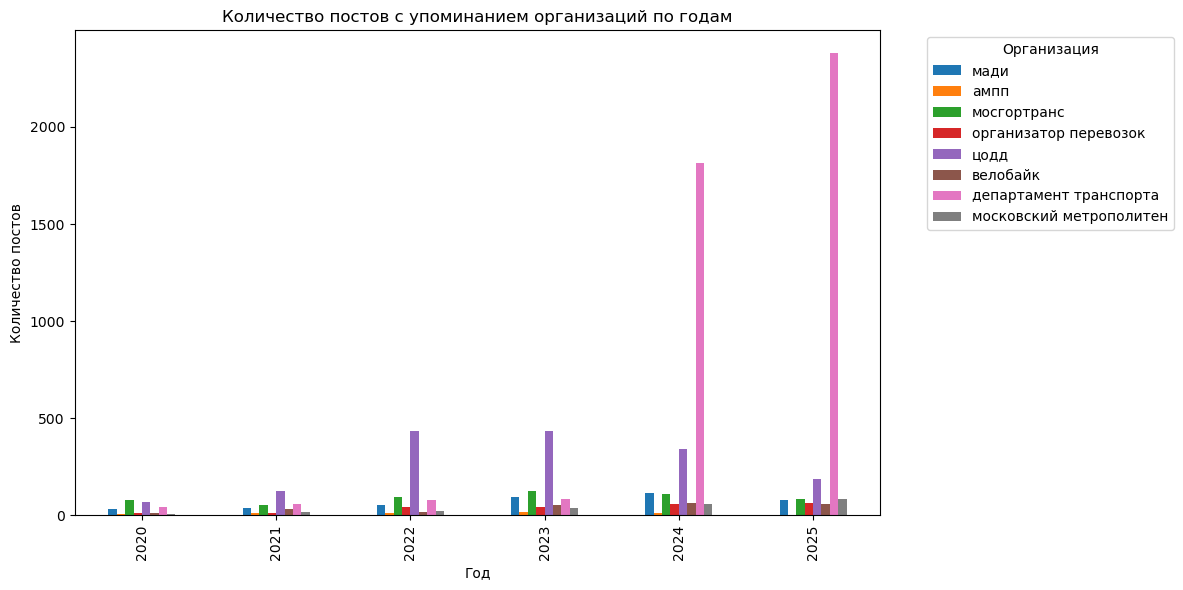

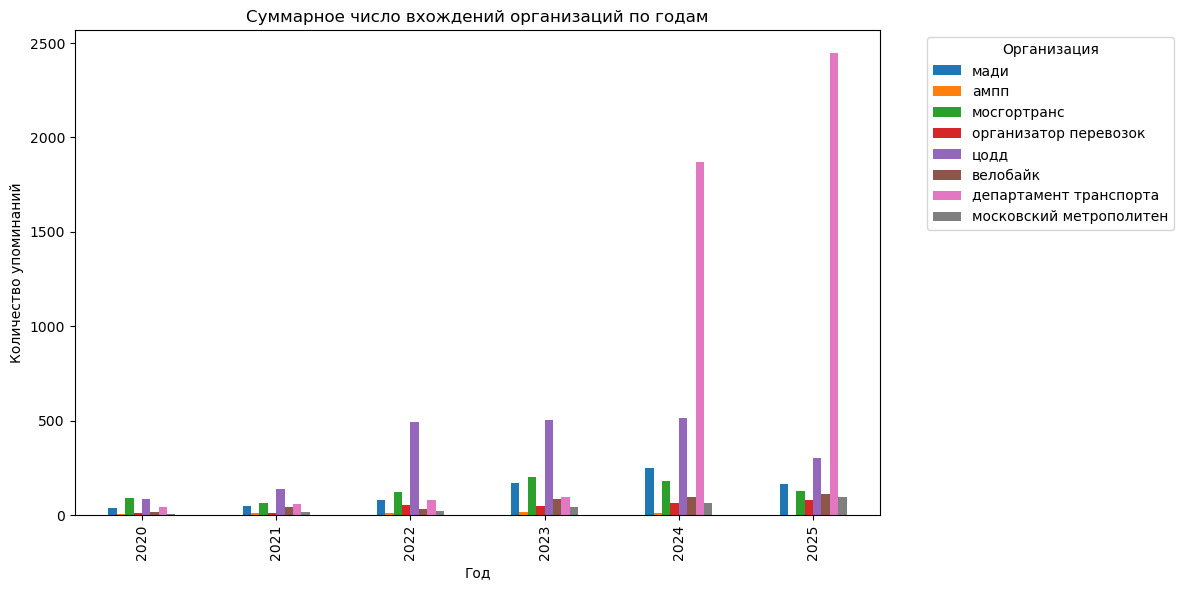

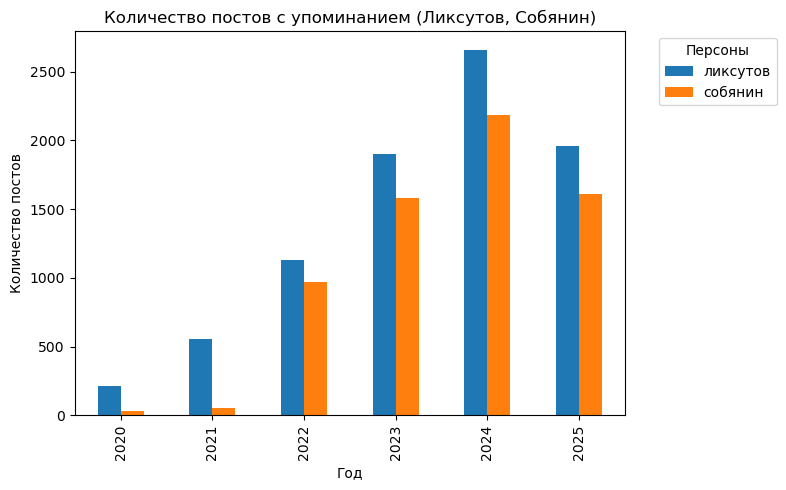

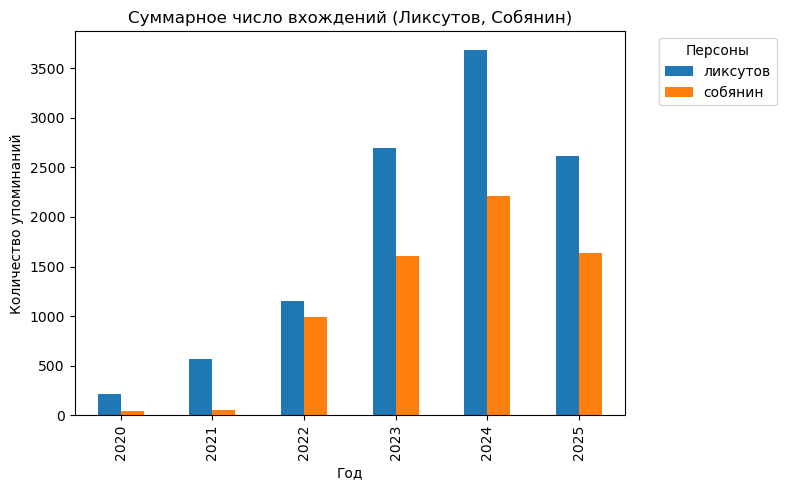

In [43]:
# построим графики
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Фильтруем: организации (без Ликсутова и Собянина), чтобы графики были красивые
org_cols_posts = [col for col in mentions_posts_by_year.columns if col not in ["ликсутов", "собянин"]]
org_cols_occ   = [col for col in mentions_occ_by_year.columns if col not in ["ликсутов", "собянин"]]

# Графики для организаций
plt.figure(figsize=(12, 6))
mentions_posts_by_year[org_cols_posts].plot(kind='bar', ax=plt.gca())
plt.title("Количество постов с упоминанием организаций по годам")
plt.xlabel("Год")
plt.ylabel("Количество постов")
plt.legend(title="Организация", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
mentions_occ_by_year[org_cols_occ].plot(kind='bar', ax=plt.gca())
plt.title("Суммарное число вхождений организаций по годам")
plt.xlabel("Год")
plt.ylabel("Количество упоминаний")
plt.legend(title="Организация", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Графики для Ликсутова и Собянина (персон отдельно)
pers_cols_posts = ["ликсутов", "собянин"]

plt.figure(figsize=(8, 5))
mentions_posts_by_year[pers_cols_posts].plot(kind='bar', ax=plt.gca())
plt.title("Количество постов с упоминанием (Ликсутов, Собянин)")
plt.xlabel("Год")
plt.ylabel("Количество постов")
plt.legend(title="Персоны", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
mentions_occ_by_year[pers_cols_posts].plot(kind='bar', ax=plt.gca())
plt.title("Суммарное число вхождений (Ликсутов, Собянин)")
plt.xlabel("Год")
plt.ylabel("Количество упоминаний")
plt.legend(title="Персоны", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



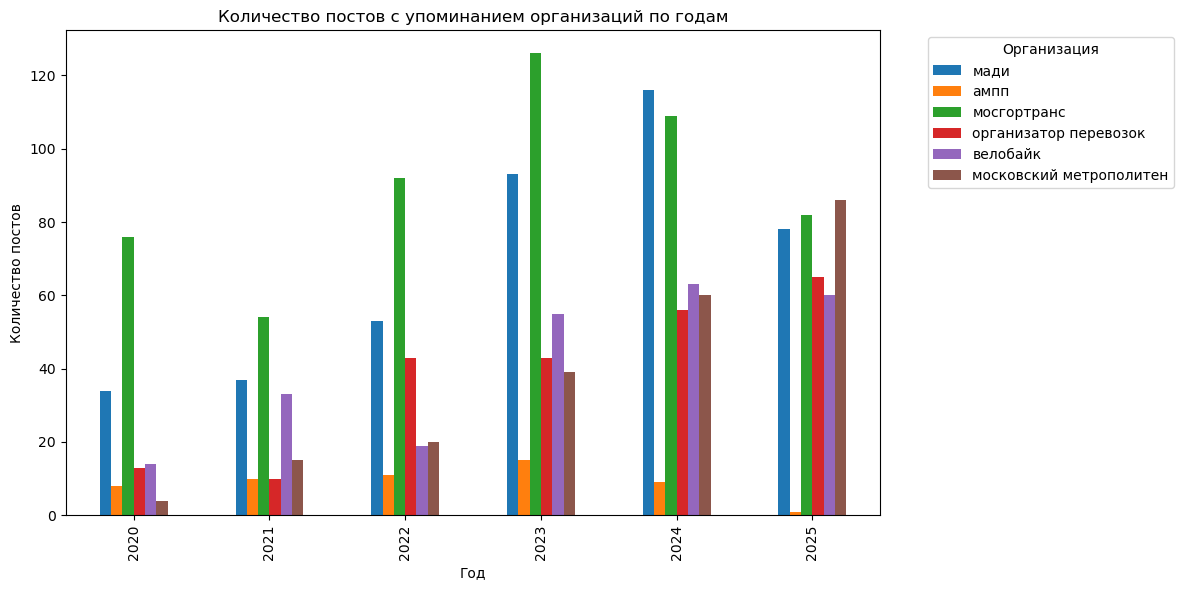

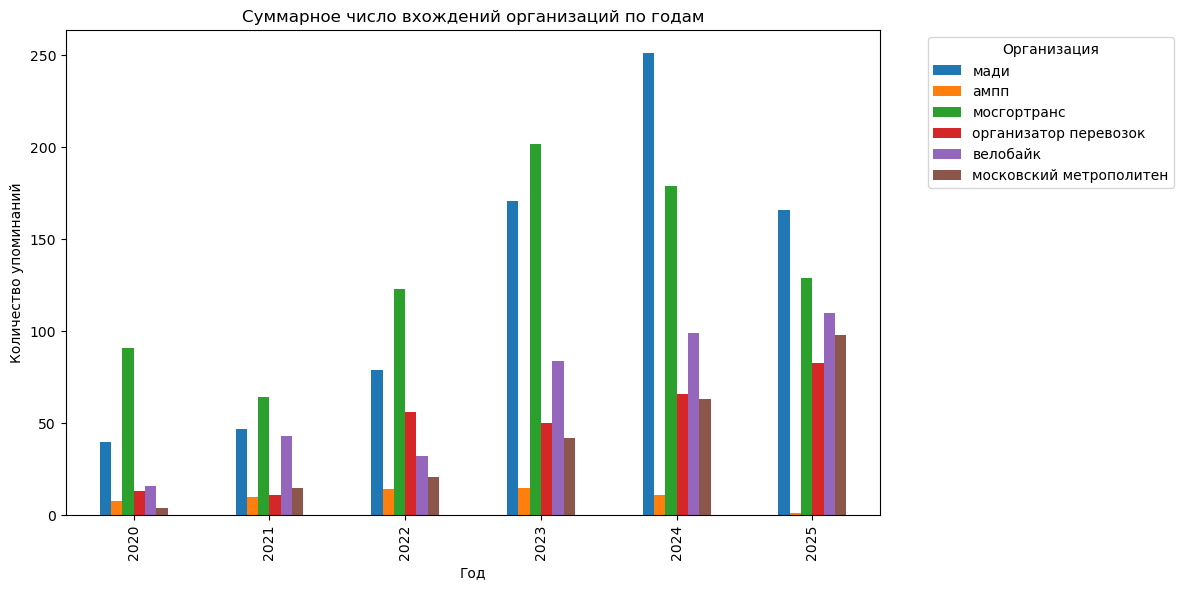

In [45]:
# поскольку у ЦОДД большие цифры, то сделаем графики без этой организации, для оценки остальных

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Фильтруем: организации (без Ликсутова, Собянина, ЦОДД, департамент транспорта), чтобы графики были красивые
org_cols_posts = [col for col in mentions_posts_by_year.columns if col not in ["ликсутов", "собянин","цодд", "департамент транспорта"]]
org_cols_occ   = [col for col in mentions_occ_by_year.columns if col not in ["ликсутов", "собянин", "цодд", "департамент транспорта"]]

# Графики для организаций
plt.figure(figsize=(12, 6))
mentions_posts_by_year[org_cols_posts].plot(kind='bar', ax=plt.gca())
plt.title("Количество постов с упоминанием организаций по годам")
plt.xlabel("Год")
plt.ylabel("Количество постов")
plt.legend(title="Организация", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
mentions_occ_by_year[org_cols_occ].plot(kind='bar', ax=plt.gca())
plt.title("Суммарное число вхождений организаций по годам")
plt.xlabel("Год")
plt.ylabel("Количество упоминаний")
plt.legend(title="Организация", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Сравним, сколько набирают просмотров публикации, где упоминается организации, и где нет

False - посты, где не упоминается организация
True → посты, где упоминается организация

In [51]:
for kw in keywords_groups:
    col = f"{kw}_flag"
    avg_views = df.groupby(col)['Просмотров'].mean()
    print(f"\n{kw}:")
    print(avg_views)



мади:
мади_flag
False    20287.924823
True     19562.537713
Name: Просмотров, dtype: float64

ампп:
ампп_flag
False    20258.071312
True     27333.592593
Name: Просмотров, dtype: float64

мосгортранс:
мосгортранс_flag
False    20227.239818
True     22239.435993
Name: Просмотров, dtype: float64

организатор перевозок:
организатор перевозок_flag
False    20284.669608
True     19310.913043
Name: Просмотров, dtype: float64

цодд:
цодд_flag
False    20063.829026
True     23101.029690
Name: Просмотров, dtype: float64

велобайк:
велобайк_flag
False    20261.411650
True     21515.381148
Name: Просмотров, dtype: float64

департамент транспорта:
департамент транспорта_flag
False    20491.762819
True     19381.818325
Name: Просмотров, dtype: float64

московский метрополитен:
московский метрополитен_flag
False    20249.901999
True     22786.580357
Name: Просмотров, dtype: float64

ликсутов:
ликсутов_flag
False    18115.519766
True     23960.846501
Name: Просмотров, dtype: float64

собянин:
собяни

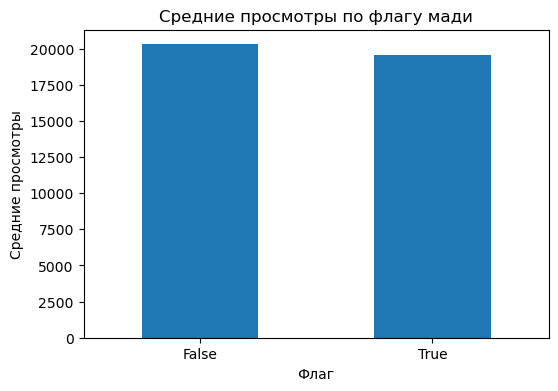

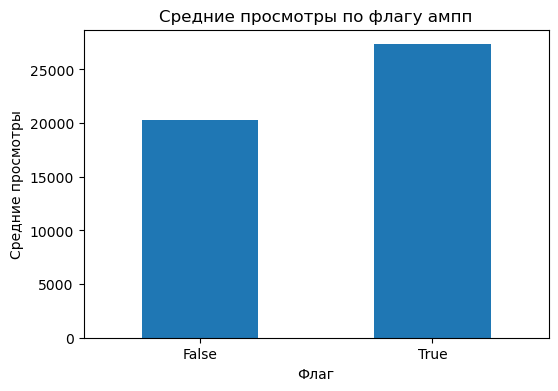

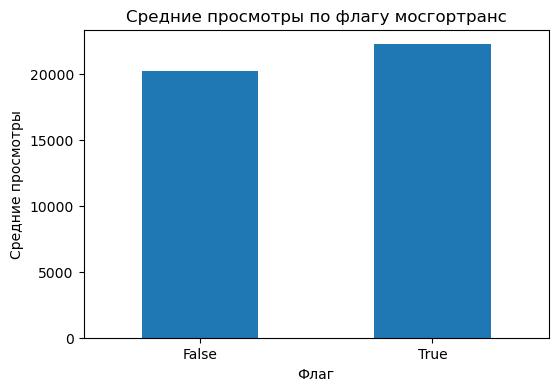

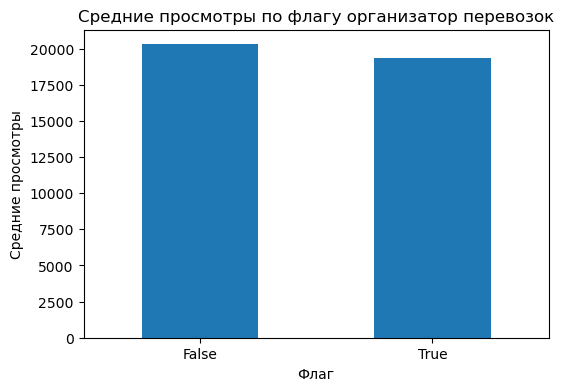

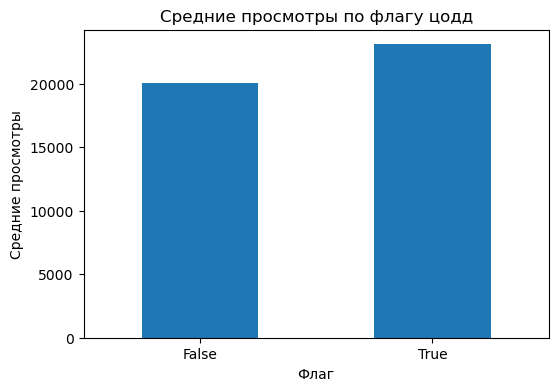

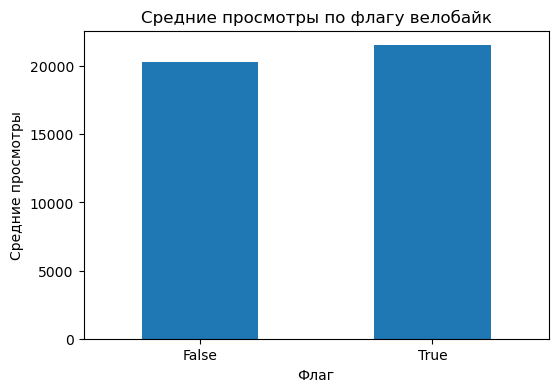

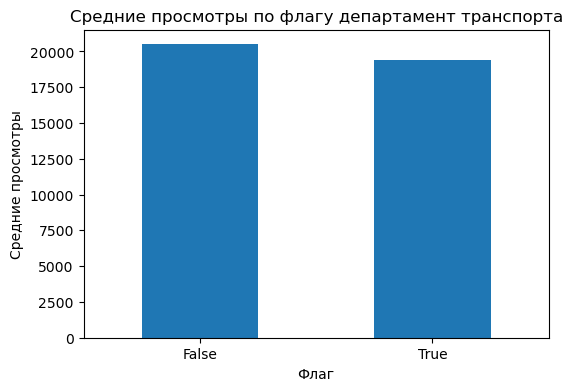

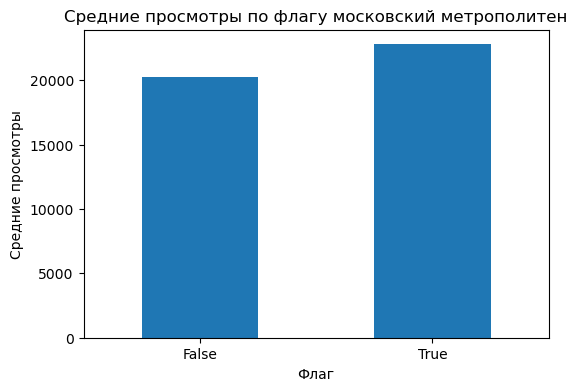

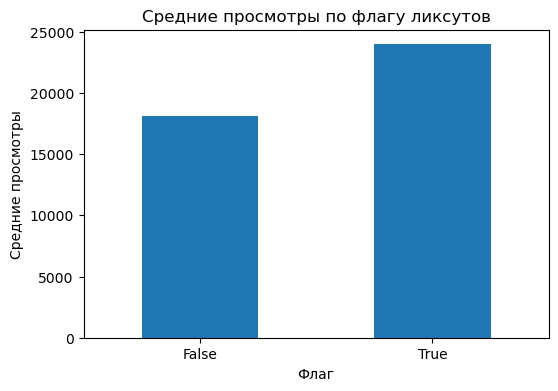

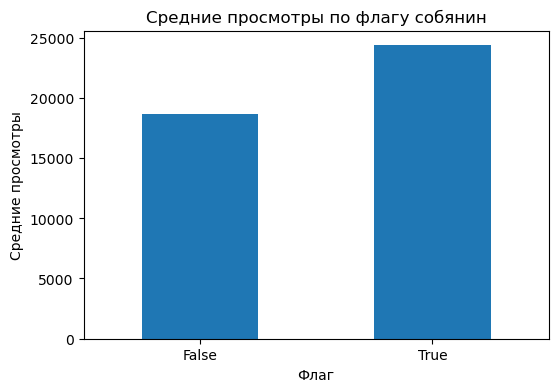

In [53]:
import matplotlib.pyplot as plt

for kw in keywords_groups:
    col = f"{kw}_flag"
    avg_views = df.groupby(col)['Просмотров'].mean()
    
    plt.figure(figsize=(6,4))
    avg_views.plot(kind='bar')
    plt.title(f"Средние просмотры по флагу {kw}")
    plt.xlabel("Флаг")
    plt.ylabel("Средние просмотры")
    plt.xticks(rotation=0)
    plt.show()

Вывод по полученным данным: исходя из графиков, чаще всего в публикациях упоминается ЦОДД и департамент транспорта, до 2024 года наблюдается тенденция роста частоты упоминания ЦОДД, в 2024 году число упоминаний организации сократилось. О такой тенденции можно сказать относительно всех подведомственных учреждений, за исключением Московского метрополитена и Организатора перевозок. Частота упоминаний этих организаций продолжает расти. 
Количество просмотров не зависит от того, есть ли упоминание организации в публикации или нет. Примерно одинаковое среднее значение у публикаций, где есть упоминание подведомственного учреждения, и других постов.

Что касается руководства, то наблюдается динамика роста их упоминаний. Чаще всего в публикациях фигурирует имя М.С. Ликсутов Публикации, где упоминается М.С.Ликсутов и С.С. Собянин, получают больше количества просмотров, чем публикации беа.

    ------ Анализ длины постов и вовлечённости

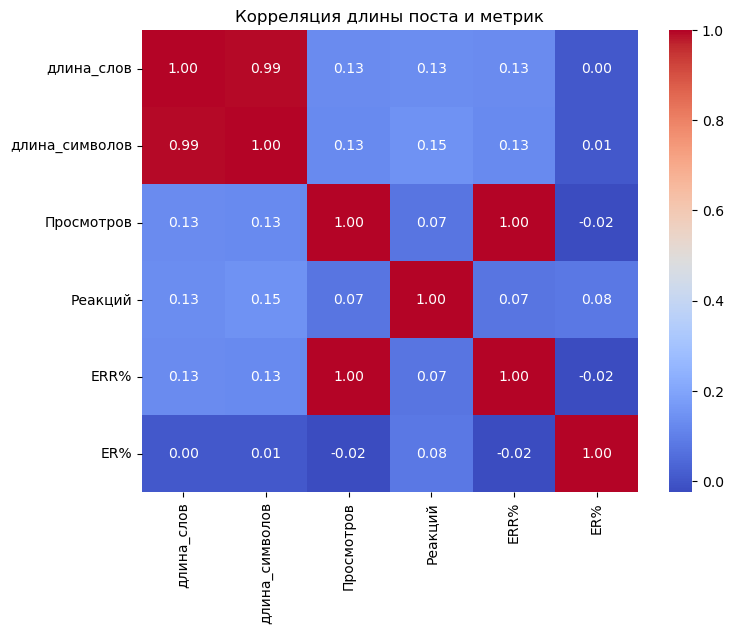

In [55]:
# считаем длину поста в словах и символах
df['длина_слов'] = df['Текст'].str.split().apply(len)
df['длина_символов'] = df['Текст'].str.len()

# корреляция между длиной и вовлечённостью
corr = df[['длина_слов', 'длина_символов', 'Просмотров', 'Реакций', 'ERR%', 'ER%']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция длины поста и метрик")
plt.show()


Вывод по полученным данным: Связь длины поста с просмотрами и реакциями слабая (0.13–0.15). Положительный коэффициент говорит о том, что чем длиннее пост, тем чуть выше просмотры и реакции, но значения 0.1–0.15 — это очень слабая корреляция, то есть зависимость почти отсутствует. Относительно длины поста и ERR% / ER%, то ERR% тоже слегка положительно коррелирует (0.13).Однако ER% стремиться к нулю (0.00–0.01), то есть длина текста никак не влияет на относительную вовлечённость (отношение реакций/просмотров). 
Таким образом, длина поста почти не влияет на просмотры, реакции и вовлечённость. Самый заметный эффект: длинные посты немного чаще набирают реакции и просмотры, но разница минимальна.

    ------ Влияние времени публикации

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1452774372.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index="День недели", columns="Час", values="Просмотров", aggfunc="mean")


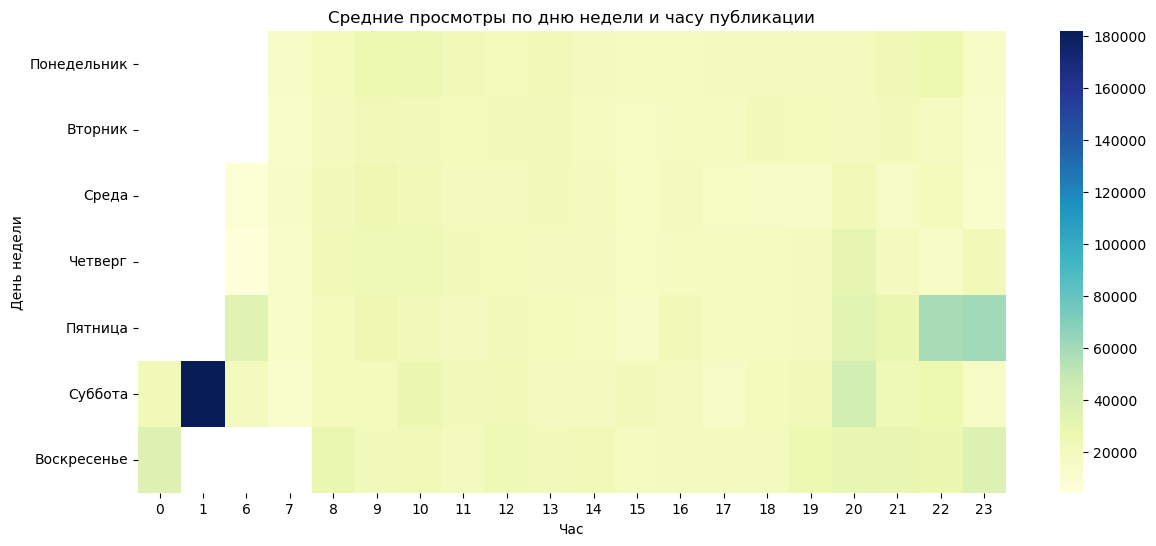

In [57]:
# извлекаем день недели и час
df['День недели'] = df['Дата публикации'].dt.day_name(locale='ru_RU')
df['Час'] = df['Дата публикации'].dt.hour

# Определите порядок дней недели
days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Установите порядок категорий для столбца "День недели"
df['День недели'] = pd.Categorical(df['День недели'], categories=days_order, ordered=True)

# средние просмотры по дням и часам
heatmap_data = df.pivot_table(index="День недели", columns="Час", values="Просмотров", aggfunc="mean")

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Средние просмотры по дню недели и часу публикации")
plt.show()


    ------ Посмотрим, какая была динамика влияния времени публикации по годам

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


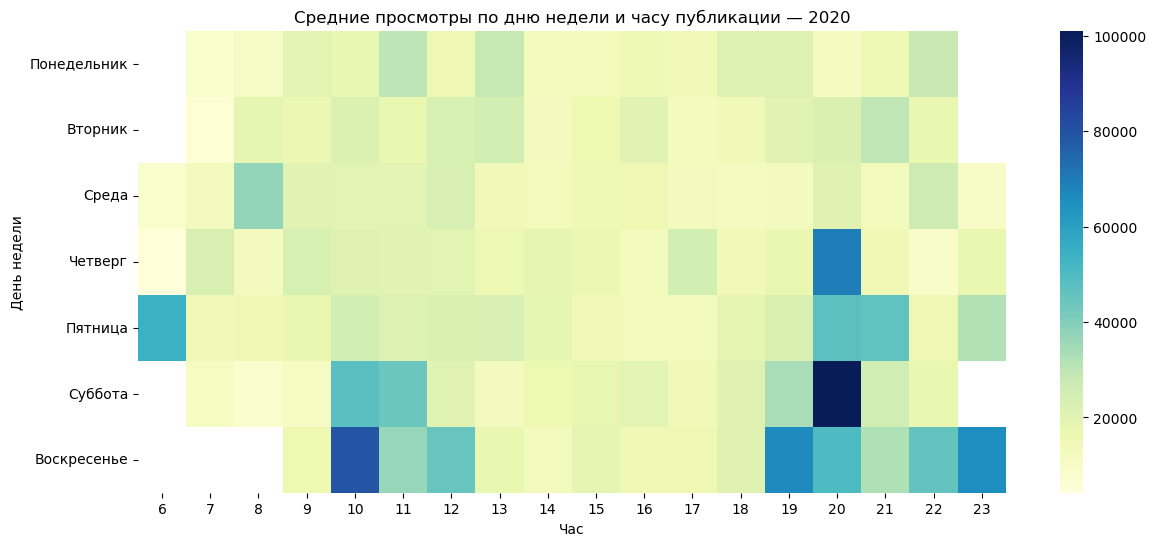

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


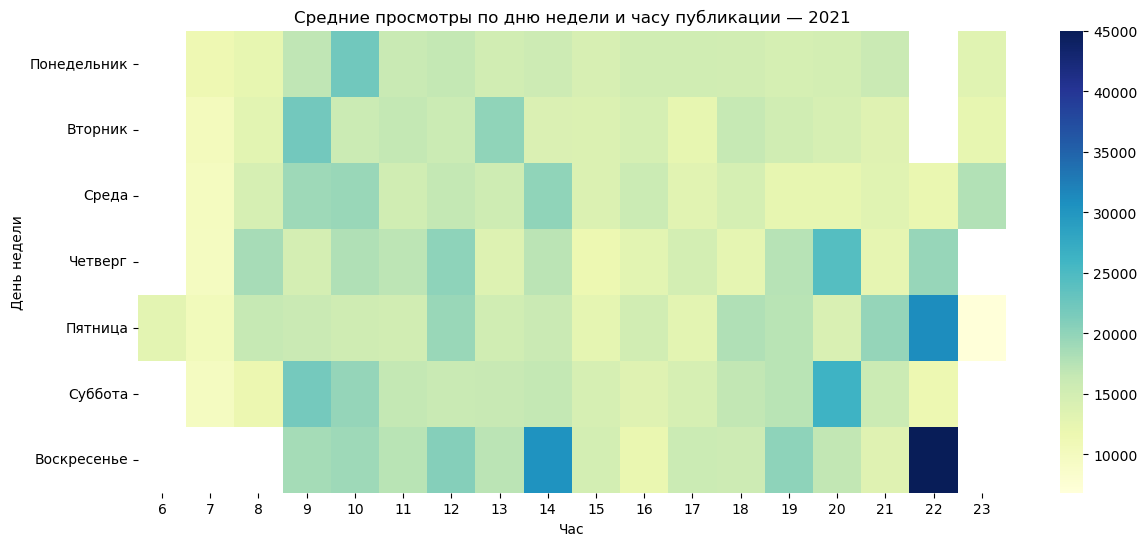

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


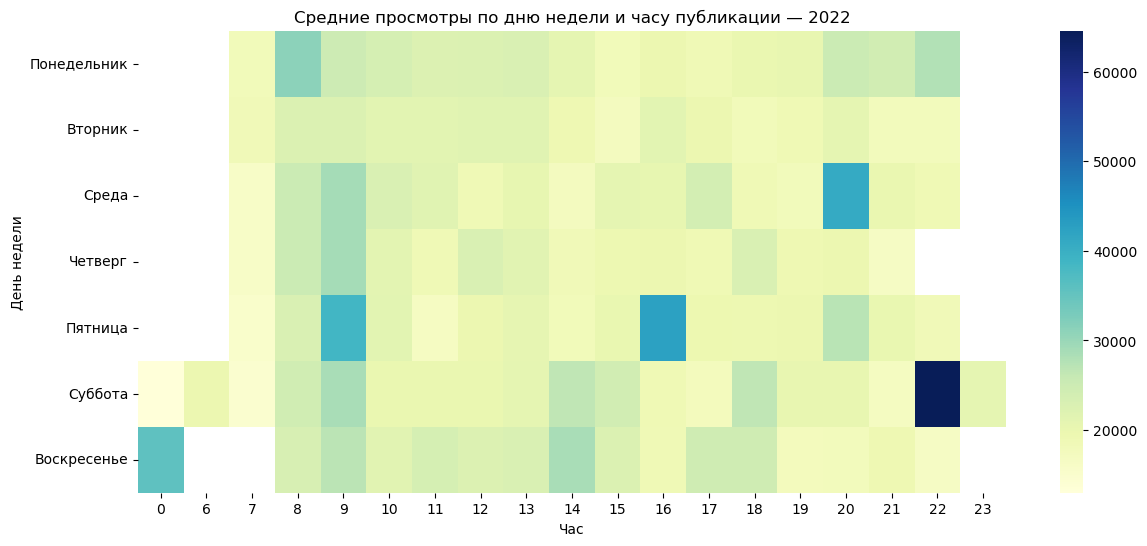

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


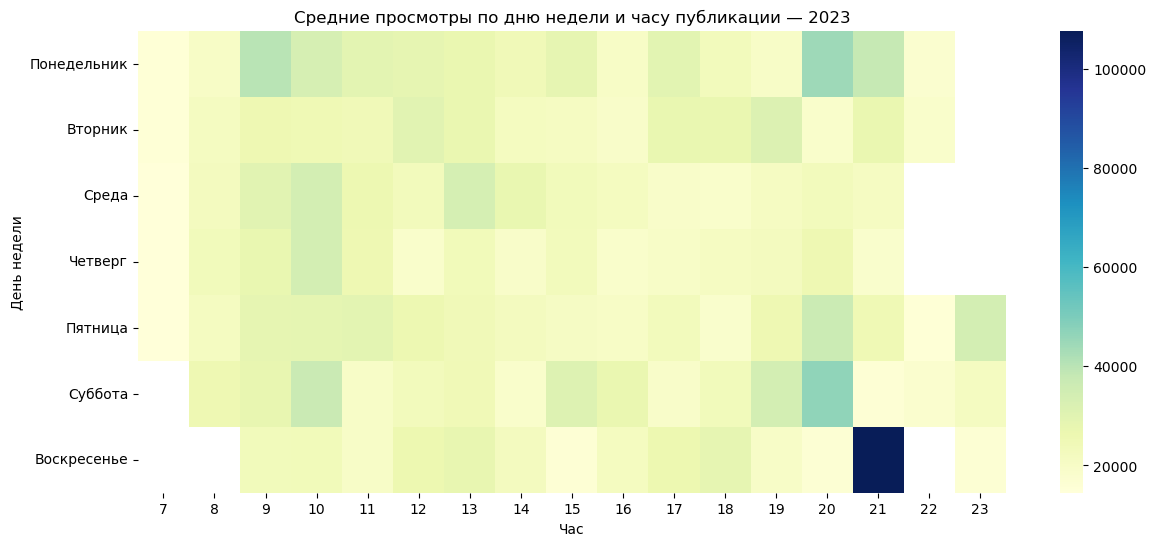

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


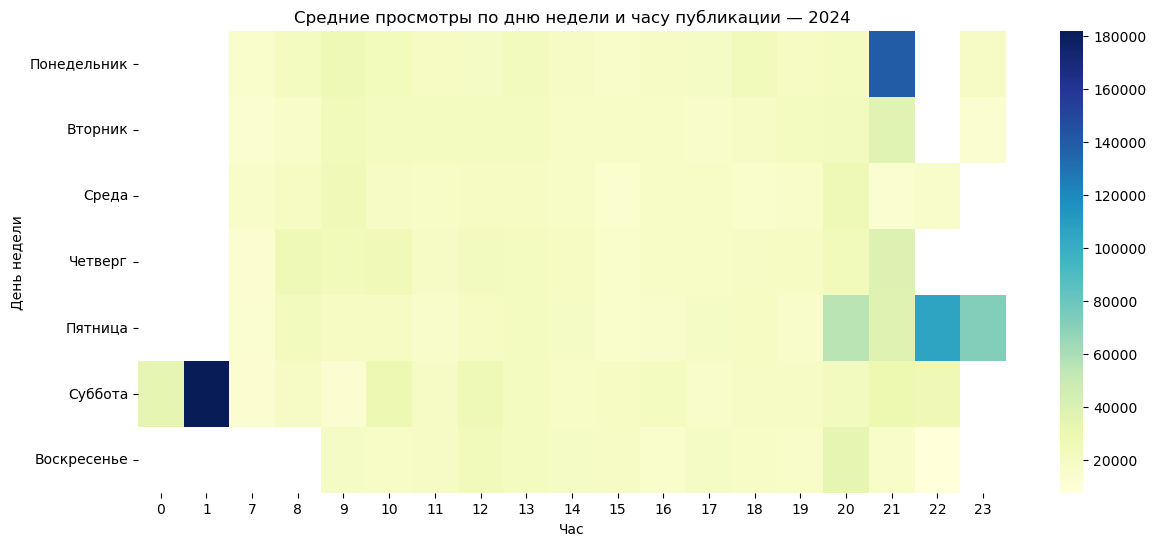

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1984360197.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_year.pivot_table(


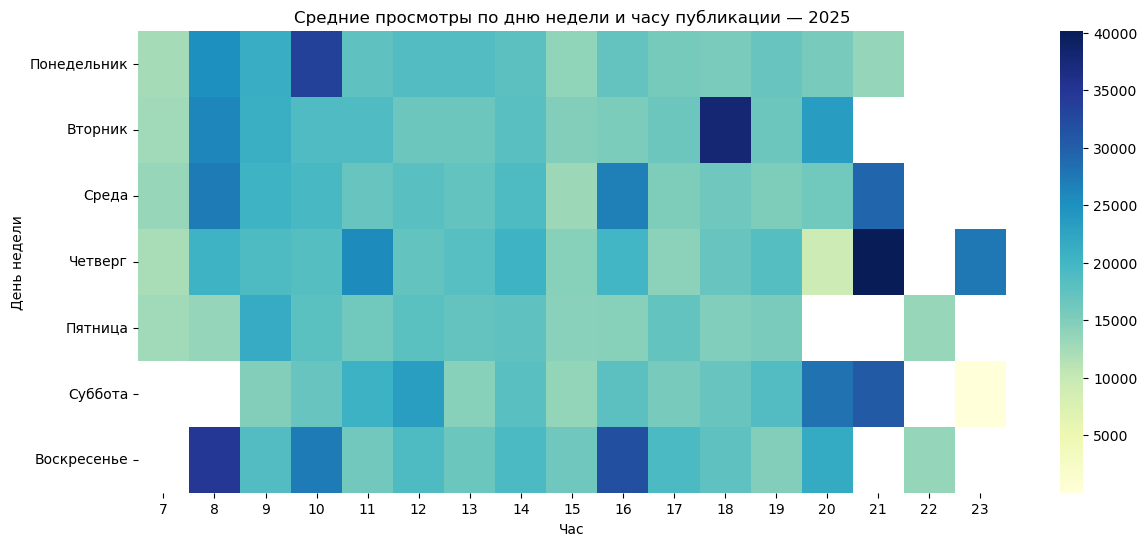

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Добавляем колонку "Год"
df['Год'] = df['Дата публикации'].dt.year

# Получаем список годов
years = sorted(df['Год'].dropna().unique())

# Определите порядок дней недели
days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Установите порядок категорий для столбца "День недели"
df['День недели'] = pd.Categorical(df['День недели'], categories=days_order, ordered=True)

# Рисуем тепловые карты по каждому году
for year in years:
    df_year = df[df['Год'] == year].copy()
    
    heatmap_data = df_year.pivot_table(
        index="День недели", 
        columns="Час", 
        values="Просмотров", 
        aggfunc="mean"
    )
    
    plt.figure(figsize=(14,6))
    sns.heatmap(heatmap_data, cmap="YlGnBu")
    plt.title(f"Средние просмотры по дню недели и часу публикации — {year}")
    plt.show()


    ------ Посмотрим сколько было постов по дням недели по годам

C:\Users\Кристина\AppData\Local\Temp\ipykernel_6380\1850534698.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Год', 'День недели'])


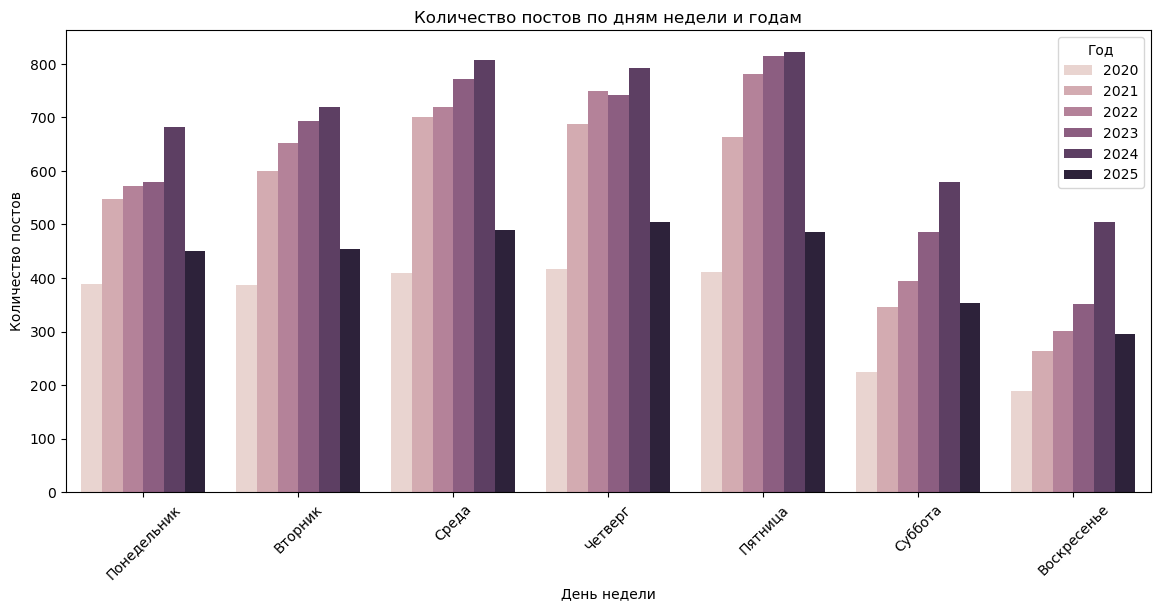

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


#  Добавим колонку "Год" и "День недели"
df['Год'] = df['Дата публикации'].dt.year
df['День недели'] = df['Дата публикации'].dt.day_name(locale='ru_RU')

# Определите порядок дней недели
days_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Установите порядок категорий для столбца "День недели"
df['День недели'] = pd.Categorical(df['День недели'], categories=days_order, ordered=True)

#  Считаем количество постов по годам и дням недели
posts_per_weekday = (
    df.groupby(['Год', 'День недели'])
      .size()
      .reset_index(name='Количество постов')
)


#  Визуализация
plt.figure(figsize=(14,6))
sns.barplot(
    data=posts_per_weekday, 
    x="День недели", 
    y="Количество постов", 
    hue="Год"
)
plt.title("Количество постов по дням недели и годам")
plt.xlabel("День недели")
plt.ylabel("Количество постов")
plt.legend(title="Год")
plt.xticks(rotation=45)
plt.show()


    ------ В тепловой карте за 5 лет, самый яркий квадрат - за субботу. Смотрим какие публикации были опубликованы в субботу промежутке с 1 до 6 часов. 

In [63]:
# Проверим, что text_col — это имя столбца, а не объект:
print("Тип text_col:", type(text_col))
print("Значение text_col:", text_col)

Тип text_col: <class 'str'>
Значение text_col: Текст


In [65]:
import pandas as pd
import os
from IPython.display import display

# Определяем датафрейм
if 'df' in globals():
    data = df.copy()
elif 'df_all' in globals():
    data = df_all.copy()
else:
    raise NameError("Не найден DataFrame 'df' или 'df_all'.")

# Находим нужные колонки
def find_col(df, keywords):
    for c in df.columns:
        low = str(c).lower()
        for k in keywords:
            if k in low:
                return c
    return None

date_col  = "Дата публикации"
text_col  = "Текст"
views_col = "Просмотров"
link_col  = "Ссылка"

if date_col is None:
    raise ValueError("Не найдена колонка с датой")
if text_col is None:
    raise ValueError("Не найдена колонка с текстом")

# Приведение дат
data[date_col] = pd.to_datetime(data[date_col], errors='coerce', dayfirst=True)
data = data.dropna(subset=[date_col]).copy()

# Час и день недели 
weekday_map = {0:'Понедельник',1:'Вторник',2:'Среда',3:'Четверг',
               4:'Пятница',5:'Суббота',6:'Воскресенье'}
data['hour'] = data[date_col].dt.hour
data['dow']  = data[date_col].dt.dayofweek.map(weekday_map)

# Фильтр: суббота 1–6 часов
mask = (data['dow'] == 'Суббота') & (data['hour'].between(1,6))
subset = data[mask].copy()

print(f"Найдено постов: {len(subset)}")

if len(subset) > 0:
    # сортировка по просмотрам если колонка есть
    if views_col:
        subset = subset.sort_values(by=views_col, ascending=False)
    
    cols_to_show = [date_col, text_col]
    if views_col: cols_to_show.insert(1, views_col)
    if link_col: cols_to_show.append(link_col)
    
    display_df = subset[cols_to_show].head(20).reset_index(drop=True)
    display_df[text_col] = display_df[text_col].astype(str).str.replace('\n',' ', regex=False).str.slice(0,300)
    
    display(display_df)
    
    if views_col:
        print("\nСтатистика просмотров:")
        print("  Сумма:", int(subset[views_col].sum()))
        print("  Медиана:", int(subset[views_col].median()))
        print("  Среднее:", round(subset[views_col].mean(), 1))
    
    out_path = os.path.join(os.getcwd(), "sat_1_6_posts.xlsx")
    subset.to_excel(out_path, index=False)
    print(f"\nСохранено в файл: {out_path}")


Найдено постов: 3


,Дата публикации,Просмотров,Текст,Ссылка
0,2024-03-23 01:33:00,340404,Сегодня в концертном зале Крокус произошла тр...,https://t.me/DtRoad/35169
1,2024-03-23 01:45:00,23422,Принял решение об отмене в эти выходные в Мос...,https://t.me/DtRoad/35170
2,2022-05-07 06:55:00,19652,​​Сегодня после реконструкции открыли станцию...,https://t.me/DtRoad/16223



Статистика просмотров:
  Сумма: 383478
  Медиана: 23422
  Среднее: 127826.0

Сохранено в файл: C:\Users\Кристина\sat_1_6_posts.xlsx


Вывод по полученным данным: На основании полученных данных можно сделать вывод, что наблюдается общая тенденция к увеличению количества публикаций по годам. Наибольшую активность пользователи проявляют в будние дни, особенно в пятницу, которая становится пиковым днем. Также стоит отметить, что среда, четверг и пятница являются наиболее насыщенными событиями днями. Если анализировать среднее количество просмотров за пятилетний период, то видно, что наибольшая активность пользователей приходится на временной промежуток с 19:00 до 6:00 утра. В то же время наименьшая активность наблюдается во вторник, когда пользователи просматривают контент значительно реже. 
Согласно тепловым картам по годам, в 2025 году активность пользователей достигает своего максимума. На карте практически нет желтых оттенков, преобладают сине-зеленые цвета, тогда как в остальные годы можно увидеть весь цветовой спектр.
Причина синего квадрата в субботу связана с террактом в Крокус-Сити 23 марта 2024.

Итоговый вывод: За исследуемый период наблюдается устойчивая тенденция к росту числа публикаций и вовлечённости пользователей. Наиболее активно аудитория взаимодействует с публикациями о транспорте (особенно рельсовом), дорожной инфраструктуре и крупных событиях.

Частота упоминаний организаций и руководителей указывает на важность информационной политики транспортного комплекса Москвы. При этом количество просмотров зависит не столько от формальных параметров (длина текста, упоминание организации), сколько от актуальности темы и значимости события.